### Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import urllib.request
import json
import sqldf
from tqdm import tqdm
from datetime import datetime


### A few additional functions 
from distance_km import get_distance ### to calculate distance (in km) between two points (lon/lat)
from cum_histogram import get_cumulative_histogram ### to plot cumulative histogram
from post_codes import get_data_from_post_codes ### to get detailed data from a post code (using postcode API)
from Lon_Lat import get_data_from_lon_lat ### to get detailed data from a loaction (lon/lat) (using postcode API)


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

### Testing the post code API to get details from post codes

In [2]:
df = get_data_from_post_codes("CB9 7UE")
df

postcode  quality  eastings  northings  country           nhs_ha  longitude  \
0  CB9 7UE        1    568074     246662  England  East of England   0.452056   

   latitude european_electoral_region primary_care_trust           region  \
0  52.09279                   Eastern            Suffolk  East of England   

                  lsoa                msoa incode outcode  \
0  St Edmundsbury 011C  St Edmundsbury 011    7UE     CB9   

  parliamentary_constituency parliamentary_constituency_2024 admin_district  \
0               West Suffolk                    West Suffolk   West Suffolk   

      parish admin_county date_of_introduction      admin_ward  \
0  Haverhill      Suffolk               202109  Haverhill East   

                            ced                               ccg  \
0  Haverhill East and Kedington  NHS Suffolk and North East Essex   

           nuts      pfa codes.admin_district codes.admin_county  \
0  West Suffolk  Suffolk            E07000245          E10000029   

  codes.admin_ward codes.parish codes.parliamentary_constituency  \
0        E05012775    E04012716                        E14001034   

  codes.parliamentary_constituency_2024  codes.ccg codes.ccg_id  codes.ced  \
0                             E14001578  E38000204          07K  E58001751   

  codes.nuts codes.lsoa codes.msoa codes.lau2  codes.pfa  
0      TLH14  E01030151  E02006283  E07000245  E23000025

### Testing the post code API to get details from longitude and lattitude

In [3]:
df = get_data_from_lon_lat(-0.15726316, 52.31654422)
df

outcode  longitude   latitude  northings  eastings     admin_district  \
0    PE29  -0.178921  52.332139     272011    524186  [Huntingdonshire]   

                        parish      admin_county  \
0  [Huntingdon, Godmanchester]  [Cambridgeshire]   

                                                                                        admin_ward  \
0  [The Stukeleys, Brampton, Godmanchester & Hemingford Abbots, Huntingdon North, Huntingdon East]   

     country parliamentary_constituency  
0  [England]               [Huntingdon]

### Load Data

In [4]:
### GPS Data

df_GPS = pd.read_csv('GPS_data.csv')

print(df_GPS.shape)

df_GPS.head()

(641662, 4)


SHIPMENT_NUMBER        LAT       LON              RECORD_TIMESTAMP
0  SEZHUK-230918-245388  53.291931 -1.072948  2023-10-09T19:25:00.000+0100
1  SEZHUK-230918-245388  53.400404 -1.078563  2023-10-09T19:40:00.000+0100
2  SEZHUK-230918-245388  53.574182 -1.215761  2023-10-09T19:55:00.000+0100
3  SEZHUK-230918-245388  53.706805 -1.336503  2023-10-09T20:10:00.000+0100
4  SEZHUK-230918-245388  53.747501 -1.640298  2023-10-09T20:25:00.000+0100

In [5]:
### check data types

df_GPS.dtypes

SHIPMENT_NUMBER      object
LAT                 float64
LON                 float64
RECORD_TIMESTAMP     object
dtype: object

In [6]:
### change timestamps to utc

df_GPS['RECORD_TIMESTAMP_lcl'] = pd.to_datetime(df_GPS['RECORD_TIMESTAMP'], errors='coerce', utc='True')

df_GPS.head()

SHIPMENT_NUMBER        LAT       LON              RECORD_TIMESTAMP  \
0  SEZHUK-230918-245388  53.291931 -1.072948  2023-10-09T19:25:00.000+0100   
1  SEZHUK-230918-245388  53.400404 -1.078563  2023-10-09T19:40:00.000+0100   
2  SEZHUK-230918-245388  53.574182 -1.215761  2023-10-09T19:55:00.000+0100   
3  SEZHUK-230918-245388  53.706805 -1.336503  2023-10-09T20:10:00.000+0100   
4  SEZHUK-230918-245388  53.747501 -1.640298  2023-10-09T20:25:00.000+0100   

       RECORD_TIMESTAMP_lcl  
0 2023-10-09 18:25:00+00:00  
1 2023-10-09 18:40:00+00:00  
2 2023-10-09 18:55:00+00:00  
3 2023-10-09 19:10:00+00:00  
4 2023-10-09 19:25:00+00:00

In [7]:
### Shipment Bookings (sb) Data

df_sb = pd.read_csv('Shipment_bookings.csv')

print(df_sb.shape)

df_sb.head()

(3245, 15)


PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   
2  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231210-272018   
3  40415fe3-e446-4d1e-b141-3698b0dc47f3  SEZHUK-231211-272127   
4  39a4e234-5d35-4d94-8e8a-b8bf6fe13953  SEZHUK-231025-256168   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000660  Tractor Unit                    Box 44ft   
2         CAUK000435  Tractor Unit                    Box 44ft   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000155  Tractor Unit                Curtain Side   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                    BD5 8LZ                RG19 4BQ   
2                    BD5 8LZ                 EN3 7QP   
3                   HP22 5BL                NG31 7UH   
4                   CV23 8BQ                 G75 0ZZ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  53.764125                   -1.740145   
2                  53.767302                   -1.746560   
3                  51.779657                   -0.772897   
4                  52.334853                   -1.180450   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               51.398851                -1.231993   
2               51.660700                -0.022247   
3               52.888113                -0.634948   
4               55.735089                -4.168719   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   
2           2023-12-14T01:20:00.000Z         2023-12-14T03:00:00.000Z   
3           2023-12-13T09:00:00.000Z         2023-12-13T09:30:00.000Z   
4           2023-11-07T14:00:00.000Z         2023-11-07T15:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z  
1        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z  
2        2023-12-14T07:03:00.000Z      2023-12-14T10:43:00.000Z  
3        2023-12-13T15:30:00.000Z      2023-12-13T16:00:00.000Z  
4        2023-11-07T23:00:00.000Z      2023-11-07T23:59:00.000Z

In [8]:
### Change timestamps to utc

df_sb['FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl'] = pd.to_datetime(df_sb['FIRST_COLLECTION_SCHEDULE_EARLIEST'], errors='coerce', utc='True')
df_sb['FIRST_COLLECTION_SCHEDULE_LATEST_lcl'] = pd.to_datetime(df_sb['FIRST_COLLECTION_SCHEDULE_LATEST'], errors='coerce', utc='True')
df_sb['LAST_DELIVERY_SCHEDULE_EARLIEST_lcl'] = pd.to_datetime(df_sb['LAST_DELIVERY_SCHEDULE_EARLIEST'], errors='coerce', utc='True')
df_sb['LAST_DELIVERY_SCHEDULE_LATEST_lcl'] = pd.to_datetime(df_sb['LAST_DELIVERY_SCHEDULE_LATEST'], errors='coerce', utc='True')
df_sb['LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30'] = pd.to_datetime(df_sb['LAST_DELIVERY_SCHEDULE_LATEST_lcl']) + pd.to_timedelta(30, unit='minute')


df_sb.head()

PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   
2  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231210-272018   
3  40415fe3-e446-4d1e-b141-3698b0dc47f3  SEZHUK-231211-272127   
4  39a4e234-5d35-4d94-8e8a-b8bf6fe13953  SEZHUK-231025-256168   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000660  Tractor Unit                    Box 44ft   
2         CAUK000435  Tractor Unit                    Box 44ft   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000155  Tractor Unit                Curtain Side   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                    BD5 8LZ                RG19 4BQ   
2                    BD5 8LZ                 EN3 7QP   
3                   HP22 5BL                NG31 7UH   
4                   CV23 8BQ                 G75 0ZZ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  53.764125                   -1.740145   
2                  53.767302                   -1.746560   
3                  51.779657                   -0.772897   
4                  52.334853                   -1.180450   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               51.398851                -1.231993   
2               51.660700                -0.022247   
3               52.888113                -0.634948   
4               55.735089                -4.168719   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   
2           2023-12-14T01:20:00.000Z         2023-12-14T03:00:00.000Z   
3           2023-12-13T09:00:00.000Z         2023-12-13T09:30:00.000Z   
4           2023-11-07T14:00:00.000Z         2023-11-07T15:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  \
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
1        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z   
2        2023-12-14T07:03:00.000Z      2023-12-14T10:43:00.000Z   
3        2023-12-13T15:30:00.000Z      2023-12-13T16:00:00.000Z   
4        2023-11-07T23:00:00.000Z      2023-11-07T23:59:00.000Z   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
1              2023-12-19 14:20:00+00:00            2023-12-19 16:00:00+00:00   
2              2023-12-14 01:20:00+00:00            2023-12-14 03:00:00+00:00   
3              2023-12-13 09:00:00+00:00            2023-12-13 09:30:00+00:00   
4              2023-11-07 14:00:00+00:00            2023-11-07 15:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
1           2023-12-20 06:00:00+00:00         2023-12-20 08:56:00+00:00   
2           2023-12-14 07:03:00+00:00         2023-12-14 10:43:00+00:00   
3           2023-12-13 15:30:00+00:00         2023-12-13 16:00:00+00:00   
4           2023-11-07 23:00:00+00:00         2023-11-07 23:59:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30  
0                2023-10-09 10:55:00+00:00  
1                2023-12-20 09:26:00+00:00  
2                2023-12-14 11:13:00+00:00  
3                2023-12-13 16:30:00+00:00  
4                2023-11-08 00:29:00+00:00

In [9]:
### New Bookings (nb) Data

df_nb = pd.read_csv('New_bookings.csv')

print(df_nb.shape)

##df_nb.head()

(1000, 15)


In [10]:
### Change timestamps to utc

df_nb['FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl'] = pd.to_datetime(df_nb['FIRST_COLLECTION_SCHEDULE_EARLIEST'], errors='coerce', utc='True')
df_nb['FIRST_COLLECTION_SCHEDULE_LATEST_lcl'] = pd.to_datetime(df_nb['FIRST_COLLECTION_SCHEDULE_LATEST'], errors='coerce', utc='True')
df_nb['LAST_DELIVERY_SCHEDULE_EARLIEST_lcl'] = pd.to_datetime(df_nb['LAST_DELIVERY_SCHEDULE_EARLIEST'], errors='coerce', utc='True')
df_nb['LAST_DELIVERY_SCHEDULE_LATEST_lcl'] = pd.to_datetime(df_nb['LAST_DELIVERY_SCHEDULE_LATEST'], errors='coerce', utc='True')
df_nb['LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30'] = pd.to_datetime(df_nb['LAST_DELIVERY_SCHEDULE_LATEST_lcl']) + pd.to_timedelta(30, unit='minute')

df_nb.head()

SHIPMENT_NUMBER                            SHIPPER_ID  CARRIER_ID  \
0  SEZHUK-240118-283413  ee7cbc7b-4f14-44ac-9c6e-086d70a27141  CAUK000872   
1  SEZHUK-240111-281159  192cd5b5-978c-4681-b206-2f4d04e081ec  CAUK000876   
2  SEZHUK-240110-280958  ee7cbc7b-4f14-44ac-9c6e-086d70a27141  CAUK000872   
3  SEZHUK-240115-282151  3244246f-e37c-4ba4-b9b3-61416a4449ae  CAUK000250   
4  SEZHUK-240110-280768  3244246f-e37c-4ba4-b9b3-61416a4449ae  CAUK000250   

   VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
0  Tractor Unit                         Box                     DUBLIN   
1  Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
2  Tractor Unit  Curtain-Side 13.6M Trailer                     DUBLIN   
3  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
4  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   

  LAST_DELIVERY_POST_CODE  FIRST_COLLECTION_LATITUDE  \
0                 DN3 3FF                  53.407411   
1                BT26 6JJ                  53.882244   
2                 DN3 3FF                  53.407411   
3                  DUBLIN                  53.293393   
4                BT36 7LQ                  53.293393   

   FIRST_COLLECTION_LONGITUDE  LAST_DELIVERY_LATITUDE  \
0                   -6.238118               53.537912   
1                   -1.267537               54.474078   
2                   -6.238118               53.537912   
3                   -1.074008               53.294121   
4                   -1.074008               54.664518   

   LAST_DELIVERY_LONGITUDE FIRST_COLLECTION_SCHEDULE_EARLIEST  \
0                -1.033570           2024-01-18T18:00:00.000Z   
1                -6.104285           2024-01-12T10:00:00.000Z   
2                -1.033570           2024-01-11T15:03:00.000Z   
3                -6.441900           2024-01-16T06:00:00.000Z   
4                -5.932184           2024-01-11T06:00:00.000Z   

  FIRST_COLLECTION_SCHEDULE_LATEST LAST_DELIVERY_SCHEDULE_EARLIEST  \
0         2024-01-18T23:00:00.000Z        2024-01-19T12:00:00.000Z   
1         2024-01-16T07:00:00.000Z        2024-01-16T07:30:00.000Z   
2         2024-01-11T15:33:00.000Z        2024-01-12T14:33:00.000Z   
3         2024-01-16T06:59:00.000Z        2024-01-18T11:01:00.000Z   
4         2024-01-11T06:59:00.000Z        2024-01-15T07:25:00.000Z   

  LAST_DELIVERY_SCHEDULE_LATEST FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl  \
0      2024-01-19T13:00:00.000Z              2024-01-18 18:00:00+00:00   
1      2024-01-16T08:00:00.000Z              2024-01-12 10:00:00+00:00   
2      2024-01-12T15:03:00.000Z              2024-01-11 15:03:00+00:00   
3      2024-01-18T11:31:00.000Z              2024-01-16 06:00:00+00:00   
4      2024-01-15T07:55:00.000Z              2024-01-11 06:00:00+00:00   

  FIRST_COLLECTION_SCHEDULE_LATEST_lcl LAST_DELIVERY_SCHEDULE_EARLIEST_lcl  \
0            2024-01-18 23:00:00+00:00           2024-01-19 12:00:00+00:00   
1            2024-01-16 07:00:00+00:00           2024-01-16 07:30:00+00:00   
2            2024-01-11 15:33:00+00:00           2024-01-12 14:33:00+00:00   
3            2024-01-16 06:59:00+00:00           2024-01-18 11:01:00+00:00   
4            2024-01-11 06:59:00+00:00           2024-01-15 07:25:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30  
0         2024-01-19 13:00:00+00:00                2024-01-19 13:30:00+00:00  
1         2024-01-16 08:00:00+00:00                2024-01-16 08:30:00+00:00  
2         2024-01-12 15:03:00+00:00                2024-01-12 15:33:00+00:00  
3         2024-01-18 11:31:00+00:00                2024-01-18 12:01:00+00:00  
4         2024-01-15 07:55:00+00:00                2024-01-15 08:25:00+00:00

### Task 1

Operational teams rely on KPIs like on-time collection and on-time delivery to gauge carrier performance. What percentage of shipments met the on-time delivery threshold (arriving no later than 30 minutes past the scheduled delivery window) between October 1st and December 31st, 2023? Please outline your assumptions.


Answer: 60.68% shipments (out of shipments with sufficient confidence of delivery confirmation, 2762); 51.65% shipments (out of total shipments).

Assumptions: 

1. Shipment is considered delivered if, 
EITHER (i) Outcode of closest GPS Location (based on distance in km) is in the nearest outcodes based on the delivery postcode.
OR (ii) Outcode of closest GPS Location is same as outcode for the last delivery location (lon/lat)

2. Shipment is considered on time if,
Recorded Timestamp of minimum distance GPS Location is less than or equal to (Latest Last Delivery Dchedule + 30 minutes).

3. Shipment is considered delivered on time if, both conditions in assumption 1 and 2 are fulfilled.

Weird bit: I have decided to work with the timestamps of minimum distance (between GPS location and delivery), instead of last recordeds GPS location.

#### Logic/Schema ####

1. Left join shipment bookings with GPS location on shipment number
2. Calculate distance between each GPS location and delivery location for each shipment number
3. Get the minimum distance between GPS location and delivery locatin for each shipment number
4. Now, each shipment get the GPS location and record timestamp for minimum distance (from step 3). Also, using the record timestamp, decide if shipment is 'on time' or not. On time is not same as 'delivered' or not!
5. I lost some minor data as I used 'LAST_DELIVERY_POST_CODE is NOT NULL' in query_2. (11 shipments out of 3245, so I won't mind it for now.)
6. Now, for this refind dataset (output_3), I use union of two approaches to decide if a shipment was delivered or not:

In [11]:
### Let's get the distance between MINIMUM Distance between gps location and delivery location of each shipment

query_1 = """select sb.*, gps.LAT, gps.LON, gps.RECORD_TIMESTAMP_lcl     
            from df_sb AS sb
            left join df_GPS AS gps
            on sb.SHIPMENT_NUMBER = gps.SHIPMENT_NUMBER 
            AND DATE(sb.LAST_DELIVERY_SCHEDULE_LATEST_lcl) BETWEEN '2023-10-01' AND '2023-12-31'"""
 
output_1 = sqldf.run(query_1).drop(columns=['index'])

output_1 = get_distance(output_1)

query_2 = """select SHIPMENT_NUMBER, MIN(distance) AS min_distance 
            from output_1
            where distance is not null AND LAST_DELIVERY_POST_CODE is NOT NULL
            group by 1
            """
 
output_2 = sqldf.run(query_2)

#print(output_2.shape)

query_3 = """select o1.PROJECT_ID, 
                         o1.SHIPMENT_NUMBER, 
                         o1.CARRIER_DISPLAY_ID, 
                         o1.VEHICLE_SIZE,
                         o1.VEHICLE_BUILD_UP, 
                         o1.FIRST_COLLECTION_POST_CODE,
                         o1.LAST_DELIVERY_POST_CODE, 
                         o1.FIRST_COLLECTION_LATITUDE,
                         o1.FIRST_COLLECTION_LONGITUDE, 
                         o1.LAST_DELIVERY_LATITUDE,
                         o1.LAST_DELIVERY_LONGITUDE, 
                         o1.FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl,
                         o1.FIRST_COLLECTION_SCHEDULE_LATEST_lcl,
                         o1.LAST_DELIVERY_SCHEDULE_EARLIEST_lcl,
                         o1.LAST_DELIVERY_SCHEDULE_LATEST_lcl,
                         o1.LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30,
                         o1.distance,
                         MIN(o1.LAT) AS LAT, 
                         MIN(o1.LON) AS LON,
                         MAX(o1.RECORD_TIMESTAMP_lcl) as RECORD_TIMESTAMP_lcl,
                         case when MAX(o1.RECORD_TIMESTAMP_lcl) <= o1.LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30 then 1 else 0 end as on_time
              from output_1 AS o1
              join output_2 AS o2
              on o1.SHIPMENT_NUMBER = o2.SHIPMENT_NUMBER AND o1.distance = o2.min_distance
              group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17"""

output_3 = sqldf.run(query_3)

#output_3_late_deliveries = sqldf.run(query_3)

print(output_3.shape)

output_3.head()

(3234, 21)


PROJECT_ID       SHIPMENT_NUMBER  \
0  09585ac3-30ad-4115-b56c-878a25db4b76  SEZHUK-231212-272534   
1  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230928-248367   
2  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230928-248368   
3  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230929-248494   
4  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-231002-249266   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000034  Tractor Unit                Curtain Side   
1         CAUK000222  Tractor Unit  Curtain-Side 13.6M Trailer   
2         CAUK000222  Tractor Unit  Curtain-Side 13.6M Trailer   
3         CAUK000618  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000235  Tractor Unit  Curtain-Side 13.6M Trailer   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   MK42 0PE                 M11 4BD   
1                   DE14 2WT                CV10 7SD   
2                   DE14 2WT                 B69 3EH   
3                   DE14 2WT                 PA4 8DJ   
4                   DE14 2WT                SO16 0AW   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.119510                   -0.429752   
1                  52.800481                   -1.663328   
2                  52.800481                   -1.663328   
3                  52.800481                   -1.663328   
4                  52.800481                   -1.663328   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               53.483017                -2.193588   
1               52.496170                -1.477705   
2               52.509485                -2.020513   
3               55.873398                -4.404767   
4               50.933604                -1.471132   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-12-12 14:00:00+00:00            2023-12-12 15:00:00+00:00   
1              2023-09-29 14:00:00+00:00            2023-10-02 12:00:00+00:00   
2              2023-10-04 14:00:00+00:00            2023-10-05 16:00:00+00:00   
3              2023-10-02 13:00:00+00:00            2023-10-02 13:30:00+00:00   
4              2023-10-03 18:00:00+00:00            2023-10-03 18:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-12-12 19:00:00+00:00         2023-12-12 20:00:00+00:00   
1           2023-10-02 08:00:00+00:00         2023-10-02 12:00:00+00:00   
2           2023-10-05 12:00:00+00:00         2023-10-05 16:00:00+00:00   
3           2023-10-03 07:30:00+00:00         2023-10-03 08:00:00+00:00   
4           2023-10-04 05:30:00+00:00         2023-10-04 06:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30  distance        LAT       LON  \
0                2023-12-12 20:30:00+00:00  0.159757  53.481787 -2.194833   
1                2023-10-02 12:30:00+00:00  0.271742  52.497515 -1.481055   
2                2023-10-05 16:30:00+00:00  0.040907  52.509299 -2.019992   
3                2023-10-03 08:30:00+00:00  0.559221  55.869178 -4.399897   
4                2023-10-04 06:30:00+00:00  0.031928  50.933717 -1.471551   

        RECORD_TIMESTAMP_lcl  on_time  
0  2023-12-13 08:03:00+00:00        0  
1  2023-10-02 05:57:00+00:00        1  
2  2023-10-05 08:01:00+00:00        1  
3  2023-10-03 07:34:00+00:00        1  
4  2023-10-03 19:01:00+00:00        1

In [12]:
output_3.on_time.sum()

2362

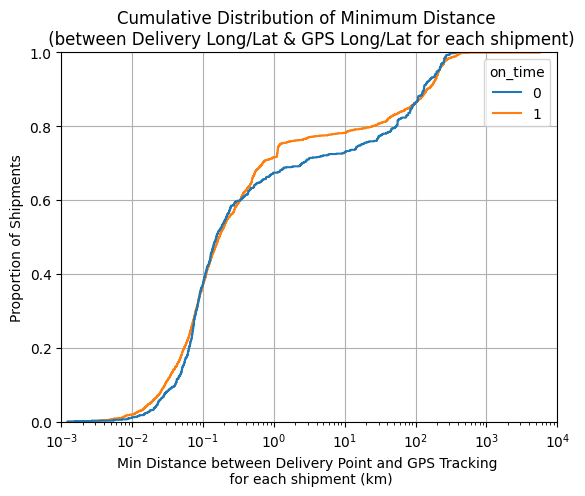

In [13]:
### cumulative histogram to compare shipments on_time or not!

get_cumulative_histogram(output_3, X='distance', HUE = 'on_time')

In [14]:
### If GPS location (LAT/LON) (based on minimum distance) has same outcode as last delivery post codes....
### then we conclude shipment is delivered.

output_3['is_delivered'] = 0
is_delivered = []

for (i, j, k) in output_3[['LAT', 'LON', 'LAST_DELIVERY_POST_CODE']].values:
    #print(j, i, k[0:3])
    df_1 = get_data_from_lon_lat(j, i)
    df_2 = get_data_from_post_codes(k)
    if df_1 is not None and df_2 is not None:
        #print(df_2.outcode.values[0], df_1.outcode.values)
        if df_2.outcode.values[0] in df_1.outcode.values:
            is_delivered.append(1)
        else:
            is_delivered.append(0)
    else:
        is_delivered.append(None)

    if (len(is_delivered)%100)==0:
        print(len(is_delivered), ' out of ', output_3.shape[0], ' rows completed.')
    if (len(is_delivered) == output_3.shape[0]):
        print('Calculations completed.')
        
output_3['is_delivered'] = is_delivered

100  out of  3234  rows completed.
200  out of  3234  rows completed.
300  out of  3234  rows completed.
400  out of  3234  rows completed.
500  out of  3234  rows completed.
600  out of  3234  rows completed.
700  out of  3234  rows completed.
800  out of  3234  rows completed.
900  out of  3234  rows completed.
1000  out of  3234  rows completed.
1100  out of  3234  rows completed.
1200  out of  3234  rows completed.
1300  out of  3234  rows completed.
1400  out of  3234  rows completed.
1500  out of  3234  rows completed.
1600  out of  3234  rows completed.
1700  out of  3234  rows completed.
1800  out of  3234  rows completed.
1900  out of  3234  rows completed.
2000  out of  3234  rows completed.
2100  out of  3234  rows completed.
2200  out of  3234  rows completed.
2300  out of  3234  rows completed.
2400  out of  3234  rows completed.
2500  out of  3234  rows completed.
2600  out of  3234  rows completed.
2700  out of  3234  rows completed.
2800  out of  3234  rows completed.
2

In [15]:
### If GPS location (LAT/LON) (based on minimum distance) has same outcode as last delivery location (LAT/LON)....
### then we conclude shipment is delivered.

output_3['is_delivered_2'] = 0
is_delivered_2 = []

for (i, j, k, l) in output_3[['LAT', 'LON', 'LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE']].values:
    #print(j, i, k, l)
    df_1 = get_data_from_lon_lat(j, i)
    df_2 = get_data_from_lon_lat(l, k)
    if df_1 is not None and df_2 is not None:
        #print(df_2.outcode.values, df_1.outcode.values)
        if df_2.outcode.values[0] == df_1.outcode.values[0]:
            is_delivered_2.append(1)
        else:
            is_delivered_2.append(0)
    else:
        is_delivered_2.append(None)

    if (len(is_delivered_2)%100)==0:
        print(len(is_delivered_2), ' out of ', output_3.shape[0], ' rows completed.')
    if (len(is_delivered_2) == output_3.shape[0]):
        print('Calculations completed.')

output_3['is_delivered_2'] = is_delivered_2

100  out of  3234  rows completed.
200  out of  3234  rows completed.
300  out of  3234  rows completed.
400  out of  3234  rows completed.
500  out of  3234  rows completed.
600  out of  3234  rows completed.
700  out of  3234  rows completed.
800  out of  3234  rows completed.
900  out of  3234  rows completed.
1000  out of  3234  rows completed.
1100  out of  3234  rows completed.
1200  out of  3234  rows completed.
1300  out of  3234  rows completed.
1400  out of  3234  rows completed.
1500  out of  3234  rows completed.
1600  out of  3234  rows completed.
1700  out of  3234  rows completed.
1800  out of  3234  rows completed.
1900  out of  3234  rows completed.
2000  out of  3234  rows completed.
2100  out of  3234  rows completed.
2200  out of  3234  rows completed.
2300  out of  3234  rows completed.
2400  out of  3234  rows completed.
2500  out of  3234  rows completed.
2600  out of  3234  rows completed.
2700  out of  3234  rows completed.
2800  out of  3234  rows completed.
2

In [33]:
### Let's take a union of both of the two methods above (to decide if a shipment was delivered or not)

output_3['is_delivered_3'] = output_3[['is_delivered','is_delivered_2']].max(axis=1)

In [34]:
### Let's create a Model_Target 
### (1 is shipment delivered late or not delivered at all, 0 is shipment was delivered on time)

query_4 = """select *, 
                      case when is_delivered_3 = 1 and on_time = 1 then 0
                       when is_delivered_3 = 1 and on_time = 0 then 1 
                       when is_delivered_3 = 0 and on_time = 1 then 1 
                       when is_delivered_3 = 0 and on_time = 0 then 1 end AS Model_Target
            from output_3
            where is_delivered_3 is not NULL
            """
 
output_4 = sqldf.run(query_4).drop(columns=['index'])

print(output_4.shape)

output_4.head()

(2762, 25)


PROJECT_ID       SHIPMENT_NUMBER  \
0  09585ac3-30ad-4115-b56c-878a25db4b76  SEZHUK-231212-272534   
1  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230928-248367   
2  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230928-248368   
3  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230929-248494   
4  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-231002-249266   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000034  Tractor Unit                Curtain Side   
1         CAUK000222  Tractor Unit  Curtain-Side 13.6M Trailer   
2         CAUK000222  Tractor Unit  Curtain-Side 13.6M Trailer   
3         CAUK000618  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000235  Tractor Unit  Curtain-Side 13.6M Trailer   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   MK42 0PE                 M11 4BD   
1                   DE14 2WT                CV10 7SD   
2                   DE14 2WT                 B69 3EH   
3                   DE14 2WT                 PA4 8DJ   
4                   DE14 2WT                SO16 0AW   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.119510                   -0.429752   
1                  52.800481                   -1.663328   
2                  52.800481                   -1.663328   
3                  52.800481                   -1.663328   
4                  52.800481                   -1.663328   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               53.483017                -2.193588   
1               52.496170                -1.477705   
2               52.509485                -2.020513   
3               55.873398                -4.404767   
4               50.933604                -1.471132   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-12-12 14:00:00+00:00            2023-12-12 15:00:00+00:00   
1              2023-09-29 14:00:00+00:00            2023-10-02 12:00:00+00:00   
2              2023-10-04 14:00:00+00:00            2023-10-05 16:00:00+00:00   
3              2023-10-02 13:00:00+00:00            2023-10-02 13:30:00+00:00   
4              2023-10-03 18:00:00+00:00            2023-10-03 18:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-12-12 19:00:00+00:00         2023-12-12 20:00:00+00:00   
1           2023-10-02 08:00:00+00:00         2023-10-02 12:00:00+00:00   
2           2023-10-05 12:00:00+00:00         2023-10-05 16:00:00+00:00   
3           2023-10-03 07:30:00+00:00         2023-10-03 08:00:00+00:00   
4           2023-10-04 05:30:00+00:00         2023-10-04 06:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30  distance        LAT       LON  \
0                2023-12-12 20:30:00+00:00  0.159757  53.481787 -2.194833   
1                2023-10-02 12:30:00+00:00  0.271742  52.497515 -1.481055   
2                2023-10-05 16:30:00+00:00  0.040907  52.509299 -2.019992   
3                2023-10-03 08:30:00+00:00  0.559221  55.869178 -4.399897   
4                2023-10-04 06:30:00+00:00  0.031928  50.933717 -1.471551   

        RECORD_TIMESTAMP_lcl  on_time  is_delivered  is_delivered_2  \
0  2023-12-13 08:03:00+00:00        0           1.0             1.0   
1  2023-10-02 05:57:00+00:00        1           1.0             1.0   
2  2023-10-05 08:01:00+00:00        1           1.0             1.0   
3  2023-10-03 07:34:00+00:00        1           1.0             1.0   
4  2023-10-03 19:01:00+00:00        1           1.0             1.0   

   is_delivered_3  Model_Target  
0             1.0             1  
1             1.0             0  
2             1.0             0  
3             1.0             0  
4             1.0             0

In [35]:
output_4.to_csv('output_4.csv')

In [11]:
output_4 = pd.read_csv('output_4.csv', index_col=0)

output_4.head()

PROJECT_ID       SHIPMENT_NUMBER  \
0  09585ac3-30ad-4115-b56c-878a25db4b76  SEZHUK-231212-272534   
1  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230928-248367   
2  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230928-248368   
3  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-230929-248494   
4  192cd5b5-978c-4681-b206-2f4d04e081ec  SEZHUK-231002-249266   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000034  Tractor Unit                Curtain Side   
1         CAUK000222  Tractor Unit  Curtain-Side 13.6M Trailer   
2         CAUK000222  Tractor Unit  Curtain-Side 13.6M Trailer   
3         CAUK000618  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000235  Tractor Unit  Curtain-Side 13.6M Trailer   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   MK42 0PE                 M11 4BD   
1                   DE14 2WT                CV10 7SD   
2                   DE14 2WT                 B69 3EH   
3                   DE14 2WT                 PA4 8DJ   
4                   DE14 2WT                SO16 0AW   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.119510                   -0.429752   
1                  52.800481                   -1.663328   
2                  52.800481                   -1.663328   
3                  52.800481                   -1.663328   
4                  52.800481                   -1.663328   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               53.483017                -2.193588   
1               52.496170                -1.477705   
2               52.509485                -2.020513   
3               55.873398                -4.404767   
4               50.933604                -1.471132   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-12-12 14:00:00+00:00            2023-12-12 15:00:00+00:00   
1              2023-09-29 14:00:00+00:00            2023-10-02 12:00:00+00:00   
2              2023-10-04 14:00:00+00:00            2023-10-05 16:00:00+00:00   
3              2023-10-02 13:00:00+00:00            2023-10-02 13:30:00+00:00   
4              2023-10-03 18:00:00+00:00            2023-10-03 18:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-12-12 19:00:00+00:00         2023-12-12 20:00:00+00:00   
1           2023-10-02 08:00:00+00:00         2023-10-02 12:00:00+00:00   
2           2023-10-05 12:00:00+00:00         2023-10-05 16:00:00+00:00   
3           2023-10-03 07:30:00+00:00         2023-10-03 08:00:00+00:00   
4           2023-10-04 05:30:00+00:00         2023-10-04 06:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30  distance        LAT       LON  \
0                2023-12-12 20:30:00+00:00  0.159757  53.481787 -2.194833   
1                2023-10-02 12:30:00+00:00  0.271742  52.497515 -1.481055   
2                2023-10-05 16:30:00+00:00  0.040907  52.509299 -2.019992   
3                2023-10-03 08:30:00+00:00  0.559221  55.869178 -4.399897   
4                2023-10-04 06:30:00+00:00  0.031928  50.933717 -1.471551   

        RECORD_TIMESTAMP_lcl  on_time  is_delivered  is_delivered_2  \
0  2023-12-13 08:03:00+00:00        0           1.0             1.0   
1  2023-10-02 05:57:00+00:00        1           1.0             1.0   
2  2023-10-05 08:01:00+00:00        1           1.0             1.0   
3  2023-10-03 07:34:00+00:00        1           1.0             1.0   
4  2023-10-03 19:01:00+00:00        1           1.0             1.0   

   is_delivered_3  Model_Target  
0             1.0             1  
1             1.0             0  
2             1.0             0  
3             1.0             0  
4             1.0             0

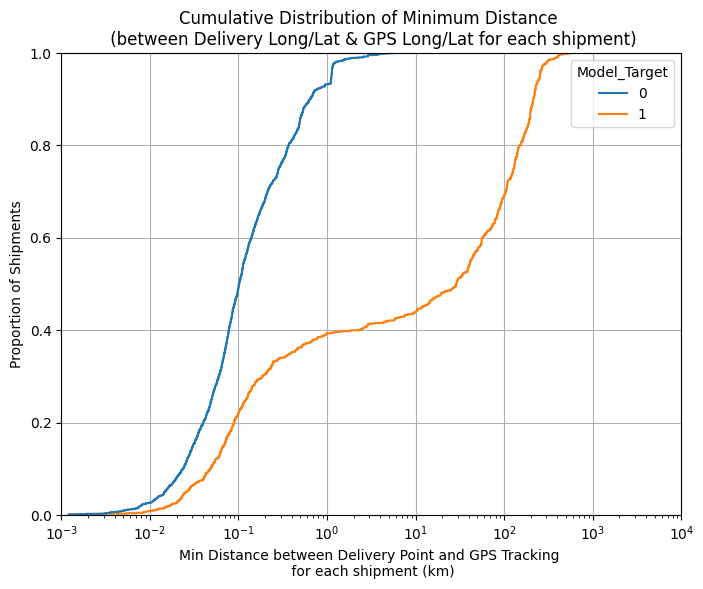

In [12]:
### plot a cumulative histogram of the shipment delivered on time (Model_Target = 0) vs NOT
fig = plt.pyplot.figure(figsize=(8, 6))
get_cumulative_histogram(output_4, X='distance', HUE = 'Model_Target')
fig.savefig('plot_1.png', dpi=500)

In [13]:
print('Percentage of shipments delivered on time :', np.round(100*len(output_4[output_4.Model_Target == 0])/len(output_4),2))

print('Percentage of shipments delivered on time (regardless):', np.round(100*len(output_4[output_4.Model_Target == 0])/len(df_sb),2))

print('Number of shipments delivered on time :', len(output_4[output_4.Model_Target == 0]))

### base line for this includes order delivered (on time or late) as well as order not delivered
print('Number of shipments in considersation :', len(output_4))

### Shipment not considered for in reporting as well as for model training: 
### For which I could not establish if the shipment was delivered or not, using the loaction data from postcode API

print('Number of shipments in original data :', len(df_sb))
### Approximately <15% excluded from reporting and model training.

Percentage of shipments delivered on time : 60.68
Percentage of shipments delivered on time (regardless): 51.65
Number of shipments delivered on time : 1676
Number of shipments in considersation : 2762
Number of shipments in original data : 3245


### Task 2

#### Predict the likelihood of delay for the list of shipments in “New_bookings.csv” dataset.

#### Let's start with output_4 to explore some features and do some more feature prepreations for a classification model!

In [14]:
df_model = output_4.drop(['PROJECT_ID', 'SHIPMENT_NUMBER', 'FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl', 'LAST_DELIVERY_SCHEDULE_EARLIEST_lcl', 'LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30', 'distance', 'LAT', 'LON', 'RECORD_TIMESTAMP_lcl', 'on_time', 'is_delivered', 'is_delivered_2', 'is_delivered_3'], axis=1)

df_model.head()

CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000034  Tractor Unit                Curtain Side   
1         CAUK000222  Tractor Unit  Curtain-Side 13.6M Trailer   
2         CAUK000222  Tractor Unit  Curtain-Side 13.6M Trailer   
3         CAUK000618  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000235  Tractor Unit  Curtain-Side 13.6M Trailer   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   MK42 0PE                 M11 4BD   
1                   DE14 2WT                CV10 7SD   
2                   DE14 2WT                 B69 3EH   
3                   DE14 2WT                 PA4 8DJ   
4                   DE14 2WT                SO16 0AW   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.119510                   -0.429752   
1                  52.800481                   -1.663328   
2                  52.800481                   -1.663328   
3                  52.800481                   -1.663328   
4                  52.800481                   -1.663328   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               53.483017                -2.193588   
1               52.496170                -1.477705   
2               52.509485                -2.020513   
3               55.873398                -4.404767   
4               50.933604                -1.471132   

  FIRST_COLLECTION_SCHEDULE_LATEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0            2023-12-12 15:00:00+00:00         2023-12-12 20:00:00+00:00   
1            2023-10-02 12:00:00+00:00         2023-10-02 12:00:00+00:00   
2            2023-10-05 16:00:00+00:00         2023-10-05 16:00:00+00:00   
3            2023-10-02 13:30:00+00:00         2023-10-03 08:00:00+00:00   
4            2023-10-03 18:00:00+00:00         2023-10-04 06:00:00+00:00   

   Model_Target  
0             1  
1             0  
2             0  
3             0  
4             0

### Some data exploration for feature engineering

In [15]:
len(df_model.CARRIER_DISPLAY_ID.unique())

87

In [16]:
len(df_nb.CARRIER_ID.unique())

121

In [17]:
print(len(df_model.VEHICLE_SIZE.unique()))

df_model.VEHICLE_SIZE.unique()

6


array(['Tractor Unit', '3.5T Van', '18T Rigid', '3.5 T Van', '26T Rigid',
       '7.5T Rigid'], dtype=object)

In [18]:
print(len(df_nb.VEHICLE_SIZE.unique()))

df_nb.VEHICLE_SIZE.unique()

6


array(['Tractor Unit', '3.5 T Van', '3.5T Van', '7.5 T', '18T Rigid',
       '7.5T Rigid'], dtype=object)

In [19]:
print(len(df_model.VEHICLE_BUILD_UP.unique()))

df_model.VEHICLE_BUILD_UP.unique()

13


array(['Curtain Side', 'Curtain-Side 13.6M Trailer',
       'Temperature-Controlled', 'Box', 'Box 44ft', 'Tractor Only',
       'LWB Van', 'High Security', '40ft Container',
       'Double Deck Trailer', 'Box 40ft', '20ft Container',
       'Tractor Only 6x2'], dtype=object)

In [20]:
print(len(df_nb.VEHICLE_BUILD_UP.unique()))

df_nb.VEHICLE_BUILD_UP.unique()

10


array(['Box', 'Curtain-Side 13.6M Trailer', 'Mega / High Cube Trailer',
       'LWB Van', 'Temperature-Controlled', 'Box 44ft',
       'Tractor Only 6x2', 'Curtain Side', 'High Security',
       'Luton Tail Lift'], dtype=object)

### Feature preperation

In [21]:
### calcualte carrier efficieny and size

query_5 = """select CARRIER_DISPLAY_ID, 
                    sum(case when Model_Target = 0 THEN 1 ELSE 0 END) AS delivered_on_time,
                    round(100.00*sum(case when Model_Target = 0 THEN 1 ELSE 0 END)/count(Model_Target),2) AS delivered_on_time_per
            from df_model
            group by CARRIER_DISPLAY_ID
            order by delivered_on_time desc"""
 
output_5 = sqldf.run(query_5)

output_5

CARRIER_DISPLAY_ID  delivered_on_time  delivered_on_time_per
0          CAUK001009                229                  93.85
1          CAUK000912                201                  86.64
2          CAUK000155                133                  70.37
3          CAUK000863                100                  48.78
4          CAUK000310                 81                  73.64
5          CAUK000435                 79                  69.30
6          CAUK001022                 75                  89.29
7          CAUK000222                 69                  45.10
8          CAUK001068                 59                  60.20
9          CAUK000766                 54                  51.92
10         CAUK000096                 54                  51.43
11         CAUK000282                 36                  83.72
12         CAUK000029                 36                  43.90
13         CAUK000490                 34                  47.89
14         CAUK000940                 32                  64.00
15         CAUK000689                 30                  27.03
16         CAUK000034                 30                  50.00
17         CAUK000770                 27                  77.14
18         CAUK000390                 25                  89.29
19         CAUK000124                 20                  57.14
20         CAUK000116                 17                  48.57
21         CAUK000618                 15                  57.69
22         CAUK000428                 15                  60.00
23         CAUK000192                 15                  57.69
24         CAUK001028                 14                  56.00
25         CAUK000250                 14                  87.50
26         CAUK000854                 13                  48.15
27         CAUK000781                 13                  65.00
28         CAUK001024                 12                  92.31
29         CAUK000876                 12                  34.29
30         CAUK000115                 12                  48.00
31         CAUK000883                  9                  50.00
32         CAUK000431                  8                 100.00
33         CAUK000660                  6                  27.27
34         CAUK000295                  6                  60.00
35         CAUK000386                  5                  26.32
36         CAUK000297                  5                  71.43
37         CAUK000565                  4                 100.00
38         CAUK000224                  4                  33.33
39         CAUK000146                  4                  57.14
40         CAUK000012                  4                 100.00
41         CAUK000993                  3                 100.00
42         CAUK000979                  3                  75.00
43         CAUK000954                  3                  75.00
44         CAUK000896                  3                 100.00
45         CAUK000446                  3                  50.00
46         CAUK000349                  3                  33.33
47         CAUK000159                  3                  27.27
48         CAUK001050                  2                 100.00
49         CAUK001047                  2                   7.69
50         CAUK000899                  2                  28.57
51         CAUK000894                  2                  66.67
52         CAUK000851                  2                 100.00
53         CAUK000814                  2                  10.00
54         CAUK000280                  2                 100.00
55         CAUK000279                  2                 100.00
56         CAUK000235                  2                  50.00
57         CAUK000184                  2                  50.00
58         CAUK000055                  2                  50.00
59         CAUK000051                  2                 100.00
60         CAUK000019                  2                 100.00
61         CAUK001006              

In [22]:
#### categorised carrier efficieny and size

query_6 = """select CARRIER_DISPLAY_ID,
                    CASE WHEN delivered_on_time >= 200 THEN 'BIG'
                         WHEN delivered_on_time >= 100 AND delivered_on_time < 200 THEN 'MEDIUM'
                         WHEN delivered_on_time >= 20 AND delivered_on_time < 100 THEN 'SMALL'
                         WHEN delivered_on_time < 20 THEN 'VERY SMALL' END AS CARRIER_SIZE,
                    CASE WHEN delivered_on_time_per >= 75 THEN 'GOOD'
                         WHEN delivered_on_time_per >= 50 AND delivered_on_time_per < 75 THEN 'OKAY'
                         WHEN delivered_on_time_per >= 25 AND delivered_on_time_per < 50 THEN 'BAD'
                         WHEN delivered_on_time_per < 25 THEN 'VERY BAD' END AS CARRIER_EFFICIENCY     
                         
            from output_5
            """
 
output_6 = sqldf.run(query_6)

output_6

CARRIER_DISPLAY_ID CARRIER_SIZE CARRIER_EFFICIENCY
0          CAUK001009          BIG               GOOD
1          CAUK000912          BIG               GOOD
2          CAUK000155       MEDIUM               OKAY
3          CAUK000863       MEDIUM                BAD
4          CAUK000310        SMALL               OKAY
5          CAUK000435        SMALL               OKAY
6          CAUK001022        SMALL               GOOD
7          CAUK000222        SMALL                BAD
8          CAUK001068        SMALL               OKAY
9          CAUK000766        SMALL               OKAY
10         CAUK000096        SMALL               OKAY
11         CAUK000282        SMALL               GOOD
12         CAUK000029        SMALL                BAD
13         CAUK000490        SMALL                BAD
14         CAUK000940        SMALL               OKAY
15         CAUK000689        SMALL                BAD
16         CAUK000034        SMALL               OKAY
17         CAUK000770        SMALL               GOOD
18         CAUK000390        SMALL               GOOD
19         CAUK000124        SMALL               OKAY
20         CAUK000116   VERY SMALL                BAD
21         CAUK000618   VERY SMALL               OKAY
22         CAUK000428   VERY SMALL               OKAY
23         CAUK000192   VERY SMALL               OKAY
24         CAUK001028   VERY SMALL               OKAY
25         CAUK000250   VERY SMALL               GOOD
26         CAUK000854   VERY SMALL                BAD
27         CAUK000781   VERY SMALL               OKAY
28         CAUK001024   VERY SMALL               GOOD
29         CAUK000876   VERY SMALL                BAD
30         CAUK000115   VERY SMALL                BAD
31         CAUK000883   VERY SMALL               OKAY
32         CAUK000431   VERY SMALL               GOOD
33         CAUK000660   VERY SMALL                BAD
34         CAUK000295   VERY SMALL               OKAY
35         CAUK000386   VERY SMALL                BAD
36         CAUK000297   VERY SMALL               OKAY
37         CAUK000565   VERY SMALL               GOOD
38         CAUK000224   VERY SMALL                BAD
39         CAUK000146   VERY SMALL               OKAY
40         CAUK000012   VERY SMALL               GOOD
41         CAUK000993   VERY SMALL               GOOD
42         CAUK000979   VERY SMALL               GOOD
43         CAUK000954   VERY SMALL               GOOD
44         CAUK000896   VERY SMALL               GOOD
45         CAUK000446   VERY SMALL               OKAY
46         CAUK000349   VERY SMALL                BAD
47         CAUK000159   VERY SMALL                BAD
48         CAUK001050   VERY SMALL               GOOD
49         CAUK001047   VERY SMALL           VERY BAD
50         CAUK000899   VERY SMALL                BAD
51         CAUK000894   VERY SMALL               OKAY
52         CAUK000851   VERY SMALL               GOOD
53         CAUK000814   VERY SMALL           VERY BAD
54         CAUK000280   VERY SMALL               GOOD
55         CAUK000279   VERY SMALL               GOOD
56         CAUK000235   VERY SMALL               OKAY
57         CAUK000184   VERY SMALL               OKAY
58         CAUK000055   VERY SMALL               OKAY
59         CAUK000051   VERY SMALL               GOOD
60         CAUK000019   VERY SMALL               GOOD
61         CAUK001006   VERY SMALL               OKAY
62         CAUK000935   VERY SMALL           VERY BAD
63         CAUK000816   VERY SMALL               GOOD
64         CAUK000815   VERY SMALL               GOOD
65         CAUK000721   VERY SMALL               GOOD
66         CAUK000695   VERY SMALL               GOOD
67         CAUK000647   VERY SMALL               GOOD
68         CAUK000529   VERY SMALL               GOOD
69         CAUK000514   VERY SMALL               GOOD
70         CAUK000363   VERY SMALL               GOOD
71         CAUK000325   VERY SMALL               OKAY
72         CAUK000179   VERY SMALL               OKAY
73     

In [23]:
### add the carreier efficiency and size to training data

query_7 = """select df_m.*, o6.CARRIER_SIZE, o6.CARRIER_EFFICIENCY
            from df_model AS df_m
            join output_6 AS o6
            on df_m.CARRIER_DISPLAY_ID = o6.CARRIER_DISPLAY_ID"""
 
df_model = sqldf.run(query_7).drop(columns=['index', 'CARRIER_DISPLAY_ID'])

df_model

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
0     Tractor Unit                Curtain Side                   MK42 0PE   
1     Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
2     Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
3     Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
4     Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
5     Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
6     Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
7     Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
8     Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
9     Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
10    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
11    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
12    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
13    Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
14    Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
15    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
16    Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
17    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
18    Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
19    Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
20    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
21    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
22    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
23    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
24    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
25    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
26    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
27    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
28    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
29    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
30    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
31    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 1PT   
32    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
33    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
34    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
35    Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
36    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
37    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
38    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
39    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
40    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
41    Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
42    Tractor Unit  Curtain-Side 13.6M Trailer                   BT26 6JJ   
43    Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
44    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 1PT   
45    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
46    Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
47    Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
48    Tractor Unit  Curtain-Side 13.6M Trailer                   DE12 8AA   
49    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
50    Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
51

In [24]:
#### add carrier efficiency and size to new booking data

query_8 = """select df_nb.*, 
                    CASE WHEN o6.CARRIER_SIZE IS NULL THEN 'UNKNOWN_1' ELSE o6.CARRIER_SIZE END AS  CARRIER_SIZE,
                    CASE WHEN o6.CARRIER_EFFICIENCY IS NULL THEN 'UNKNOWN_2' ELSE o6.CARRIER_EFFICIENCY END AS CARRIER_EFFICIENCY
            from df_nb AS df_nb
            left join output_6 AS o6
            on df_nb.CARRIER_ID = o6.CARRIER_DISPLAY_ID"""
 
df_nb = sqldf.run(query_8).drop(columns=['index', 'CARRIER_ID', 'SHIPMENT_NUMBER', 'SHIPPER_ID', \
                                         'FIRST_COLLECTION_SCHEDULE_EARLIEST', 'FIRST_COLLECTION_SCHEDULE_LATEST',\
                                         'LAST_DELIVERY_SCHEDULE_EARLIEST',	'LAST_DELIVERY_SCHEDULE_LATEST',\
                                         'FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl', 'LAST_DELIVERY_SCHEDULE_EARLIEST_lcl',\
                                        'LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30'])

df_nb

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
0    Tractor Unit                         Box                     DUBLIN   
1    Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
2    Tractor Unit  Curtain-Side 13.6M Trailer                     DUBLIN   
3    Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
4    Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
5    Tractor Unit                         Box                    DN3 3FF   
6    Tractor Unit    Mega / High Cube Trailer                   DN15 9YA   
7    Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
8       3.5 T Van                         Box                   ME16 0LE   
9    Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
10   Tractor Unit  Curtain-Side 13.6M Trailer                   GL16 8JB   
11   Tractor Unit  Curtain-Side 13.6M Trailer                   NG13 0EP   
12   Tractor Unit  Curtain-Side 13.6M Trailer                    L11 0JA   
13       3.5T Van                     LWB Van                    CO4 9QJ   
14   Tractor Unit  Curtain-Side 13.6M Trailer                   DN11 9HE   
15       3.5T Van                     LWB Van                    SL3 0BB   
16   Tractor Unit      Temperature-Controlled                       DN15   
17   Tractor Unit  Curtain-Side 13.6M Trailer                    LE3 8DX   
18   Tractor Unit  Curtain-Side 13.6M Trailer                   SK16 4UG   
19   Tractor Unit  Curtain-Side 13.6M Trailer                    WA7 4HP   
20   Tractor Unit  Curtain-Side 13.6M Trailer                    GY2 4JN   
21   Tractor Unit  Curtain-Side 13.6M Trailer                   OL15 8QF   
22       3.5T Van                         Box                    S35 2PW   
23       3.5T Van                         Box                    S35 2PW   
24   Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
25   Tractor Unit                    Box 44ft                    BD5 8LZ   
26   Tractor Unit  Curtain-Side 13.6M Trailer                   DG16 5HT   
27   Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
28   Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
29   Tractor Unit                    Box 44ft                    BD5 8LZ   
30   Tractor Unit      Temperature-Controlled                   PE10 0AT   
31   Tractor Unit                    Box 44ft                    BD5 8LZ   
32   Tractor Unit  Curtain-Side 13.6M Trailer                   GL16 8JB   
33   Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
34   Tractor Unit  Curtain-Side 13.6M Trailer                    L11 0JA   
35   Tractor Unit  Curtain-Side 13.6M Trailer                    WA7 4HP   
36       3.5T Van                         Box                    BD5 8LZ   
37   Tractor Unit  Curtain-Side 13.6M Trailer                    WA7 4HP   
38   Tractor Unit  Curtain-Side 13.6M Trailer                    DN8 5TE   
39   Tractor Unit  Curtain-Side 13.6M Trailer                    JE2 3ND   
40   Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
41   Tractor Unit  Curtain-Side 13.6M Trailer                   SS17 9DY   
42   Tractor Unit  Curtain-Side 13.6M Trailer                    LE3 8DX   
43   Tractor Unit  Curtain-Side 13.6M Trailer                   GL16 8JB   
44       3.5T Van                     LWB Van                   TS17 9NT   
45   Tractor Unit  Curtain-Side 13.6M Trailer                    DN3 3FG   
46   Tractor Unit  Curtain-Side 13.6M Trailer                   BS20 7XL   
47       3.5T Van                         Box                    S35 2PW   
48   Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
49   Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
50   Tractor Unit  Curtain-Side 13.6M Trailer                       CV23   
51   Tractor Unit  Curtain-Side 13.6M Trailer        

In [25]:
#### get distance between collection and delivery locations for training data

df_model = get_distance(df_model, lon1='LAST_DELIVERY_LONGITUDE', lat1='LAST_DELIVERY_LATITUDE',\
                        lon2='FIRST_COLLECTION_LONGITUDE', lat2='FIRST_COLLECTION_LATITUDE')

df_model.head()

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
0  Tractor Unit                Curtain Side                   MK42 0PE   
1  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
2  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
3  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
4  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   

  LAST_DELIVERY_POST_CODE  FIRST_COLLECTION_LATITUDE  \
0                 M11 4BD                  52.119510   
1                CV10 7SD                  52.800481   
2                 B69 3EH                  52.800481   
3                 PA4 8DJ                  52.800481   
4                SO16 0AW                  52.800481   

   FIRST_COLLECTION_LONGITUDE  LAST_DELIVERY_LATITUDE  \
0                   -0.429752               53.483017   
1                   -1.663328               52.496170   
2                   -1.663328               52.509485   
3                   -1.663328               55.873398   
4                   -1.663328               50.933604   

   LAST_DELIVERY_LONGITUDE FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0                -2.193588            2023-12-12 15:00:00+00:00   
1                -1.477705            2023-10-02 12:00:00+00:00   
2                -2.020513            2023-10-05 16:00:00+00:00   
3                -4.404767            2023-10-02 13:30:00+00:00   
4                -1.471132            2023-10-03 18:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl  Model_Target CARRIER_SIZE  \
0         2023-12-12 20:00:00+00:00             1        SMALL   
1         2023-10-02 12:00:00+00:00             0        SMALL   
2         2023-10-05 16:00:00+00:00             0        SMALL   
3         2023-10-03 08:00:00+00:00             0   VERY SMALL   
4         2023-10-04 06:00:00+00:00             0   VERY SMALL   

  CARRIER_EFFICIENCY    distance  
0               OKAY  192.525099  
1                BAD   36.091968  
2                BAD   40.354393  
3               OKAY  385.197472  
4               OKAY  208.071364

In [26]:
### removing a single row with NULL postcode

df_model = df_model[df_model.isnull().any(axis=1) == False]

df_model.shape

(2761, 14)

In [27]:
### removing a single row with NULL postcode

df_nb = df_nb[df_nb.isnull().any(axis=1) == False]

df_nb.shape

(998, 12)

In [28]:
#### get distance between collection and delivery locations for new booking data

df_nb = get_distance(df_nb, lon1='LAST_DELIVERY_LONGITUDE', lat1='LAST_DELIVERY_LATITUDE',\
                        lon2='FIRST_COLLECTION_LONGITUDE', lat2='FIRST_COLLECTION_LATITUDE')

df_nb.head()

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
0  Tractor Unit                         Box                     DUBLIN   
1  Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
2  Tractor Unit  Curtain-Side 13.6M Trailer                     DUBLIN   
3  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
4  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   

  LAST_DELIVERY_POST_CODE  FIRST_COLLECTION_LATITUDE  \
0                 DN3 3FF                  53.407411   
1                BT26 6JJ                  53.882244   
2                 DN3 3FF                  53.407411   
3                  DUBLIN                  53.293393   
4                BT36 7LQ                  53.293393   

   FIRST_COLLECTION_LONGITUDE  LAST_DELIVERY_LATITUDE  \
0                   -6.238118               53.537912   
1                   -1.267537               54.474078   
2                   -6.238118               53.537912   
3                   -1.074008               53.294121   
4                   -1.074008               54.664518   

   LAST_DELIVERY_LONGITUDE FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0                -1.033570            2024-01-18 23:00:00+00:00   
1                -6.104285            2024-01-16 07:00:00+00:00   
2                -1.033570            2024-01-11 15:33:00+00:00   
3                -6.441900            2024-01-16 06:59:00+00:00   
4                -5.932184            2024-01-11 06:59:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl CARRIER_SIZE CARRIER_EFFICIENCY  \
0         2024-01-19 13:00:00+00:00    UNKNOWN_1          UNKNOWN_2   
1         2024-01-16 08:00:00+00:00   VERY SMALL                BAD   
2         2024-01-12 15:03:00+00:00    UNKNOWN_1          UNKNOWN_2   
3         2024-01-18 11:31:00+00:00   VERY SMALL               GOOD   
4         2024-01-15 07:55:00+00:00   VERY SMALL               GOOD   

     distance  
0  344.794203  
1  321.606543  
2  344.794203  
3  356.792146  
4  352.384070

In [29]:
df_nb = df_nb[(df_nb.FIRST_COLLECTION_POST_CODE != 'DUBLIN') & (df_nb.LAST_DELIVERY_POST_CODE != 'DUBLIN')]

df_nb.head()

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
1  Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
4  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
6  Tractor Unit    Mega / High Cube Trailer                   DN15 9YA   
7  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
8     3.5 T Van                         Box                   ME16 0LE   

  LAST_DELIVERY_POST_CODE  FIRST_COLLECTION_LATITUDE  \
1                BT26 6JJ                  53.882244   
4                BT36 7LQ                  53.293393   
6                BT36 4PX                  53.620347   
7                OX11 7HJ                  53.295391   
8                OX26 6WD                  51.292639   

   FIRST_COLLECTION_LONGITUDE  LAST_DELIVERY_LATITUDE  \
1                   -1.267537               54.474078   
4                   -1.074008               54.664518   
6                   -0.665131               54.671797   
7                   -1.066283               51.619116   
8                    0.493261               51.892500   

   LAST_DELIVERY_LONGITUDE FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
1                -6.104285            2024-01-16 07:00:00+00:00   
4                -5.932184            2024-01-11 06:59:00+00:00   
6                -6.000939            2024-01-13 06:30:00+00:00   
7                -1.256855            2024-01-17 06:56:00+00:00   
8                -1.154503            2024-01-12 14:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl CARRIER_SIZE CARRIER_EFFICIENCY  \
1         2024-01-16 08:00:00+00:00   VERY SMALL                BAD   
4         2024-01-15 07:55:00+00:00   VERY SMALL               GOOD   
6         2024-01-13 19:00:00+00:00    UNKNOWN_1          UNKNOWN_2   
7         2024-01-17 13:17:00+00:00   VERY SMALL               GOOD   
8         2024-01-15 09:30:00+00:00    UNKNOWN_1          UNKNOWN_2   

     distance  
1  321.606543  
4  352.384070  
6  366.662560  
7  186.898466  
8  131.967474

In [30]:
#### Adding delivery and collection regions using postcode API

region_delivery = []
region_collection = []
parish_delivery = []
parish_collection = []

for (i, j) in df_model[['FIRST_COLLECTION_POST_CODE', 'LAST_DELIVERY_POST_CODE']].values:
    df_1 = get_data_from_post_codes(i)
    df_2 = get_data_from_post_codes(j)
    if df_1 is not None:
        region_collection.append(df_1.region[0])
        parish_collection.append(df_1.parish[0])
    else:
        region_collection.append(None)
        parish_collection.append(None)

    if df_2 is not None:
        region_delivery.append(df_2.region[0])
        parish_delivery.append(df_2.parish[0])
    else:
        region_delivery.append(None)
        parish_delivery.append(None)

    if (len(region_collection)%100)==0:
        print(len(region_collection), ' out of ', df_model.shape[0], ' rows completed.')
    if (len(region_collection) == df_model.shape[0]):
        print('Calculations completed.')

new_data = {"region_delivery": region_delivery, "region_collection": region_collection, \
           "parish_delivery": parish_delivery, "parish_collection": parish_collection}
df_model = df_model.assign(**new_data)

100  out of  2761  rows completed.
200  out of  2761  rows completed.
300  out of  2761  rows completed.
400  out of  2761  rows completed.
500  out of  2761  rows completed.
600  out of  2761  rows completed.
700  out of  2761  rows completed.
800  out of  2761  rows completed.
900  out of  2761  rows completed.
1000  out of  2761  rows completed.
1100  out of  2761  rows completed.
1200  out of  2761  rows completed.
1300  out of  2761  rows completed.
1400  out of  2761  rows completed.
1500  out of  2761  rows completed.
1600  out of  2761  rows completed.
1700  out of  2761  rows completed.
1800  out of  2761  rows completed.
1900  out of  2761  rows completed.
2000  out of  2761  rows completed.
2100  out of  2761  rows completed.
2200  out of  2761  rows completed.
2300  out of  2761  rows completed.
2400  out of  2761  rows completed.
2500  out of  2761  rows completed.
2600  out of  2761  rows completed.
2700  out of  2761  rows completed.
Calculations completed.


In [31]:
#### Adding delivery and collection regions using postcode API

region_delivery = []
region_collection = []
parish_delivery = []
parish_collection = []

for (i, j) in df_nb[['FIRST_COLLECTION_POST_CODE', 'LAST_DELIVERY_POST_CODE']].values:
    df_1 = get_data_from_post_codes(i)
    df_2 = get_data_from_post_codes(j)
    if df_1 is not None:
        region_collection.append(df_1.region[0])
        parish_collection.append(df_1.parish[0])
    else:
        region_collection.append(None)
        parish_collection.append(None)

    if df_2 is not None:
        region_delivery.append(df_2.region[0])
        parish_delivery.append(df_2.parish[0])
    else:
        region_delivery.append(None)
        parish_delivery.append(None)

    if (len(region_collection)%100)==0:
        print(len(region_collection), ' out of ', df_nb.shape[0], ' rows completed.')
    if (len(region_collection) == df_nb.shape[0]):
        print('Calculations completed.')


new_data = {"region_delivery": region_delivery, "region_collection": region_collection, \
           "parish_delivery": parish_delivery, "parish_collection": parish_collection}
df_nb = df_nb.assign(**new_data)

100  out of  985  rows completed.
200  out of  985  rows completed.
300  out of  985  rows completed.
400  out of  985  rows completed.
500  out of  985  rows completed.
600  out of  985  rows completed.
700  out of  985  rows completed.
800  out of  985  rows completed.
900  out of  985  rows completed.
Calculations completed.


In [32]:
df_model.head()

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
0  Tractor Unit                Curtain Side                   MK42 0PE   
1  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
2  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
3  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
4  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   

  LAST_DELIVERY_POST_CODE  FIRST_COLLECTION_LATITUDE  \
0                 M11 4BD                  52.119510   
1                CV10 7SD                  52.800481   
2                 B69 3EH                  52.800481   
3                 PA4 8DJ                  52.800481   
4                SO16 0AW                  52.800481   

   FIRST_COLLECTION_LONGITUDE  LAST_DELIVERY_LATITUDE  \
0                   -0.429752               53.483017   
1                   -1.663328               52.496170   
2                   -1.663328               52.509485   
3                   -1.663328               55.873398   
4                   -1.663328               50.933604   

   LAST_DELIVERY_LONGITUDE FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0                -2.193588            2023-12-12 15:00:00+00:00   
1                -1.477705            2023-10-02 12:00:00+00:00   
2                -2.020513            2023-10-05 16:00:00+00:00   
3                -4.404767            2023-10-02 13:30:00+00:00   
4                -1.471132            2023-10-03 18:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl  Model_Target CARRIER_SIZE  \
0         2023-12-12 20:00:00+00:00             1        SMALL   
1         2023-10-02 12:00:00+00:00             0        SMALL   
2         2023-10-05 16:00:00+00:00             0        SMALL   
3         2023-10-03 08:00:00+00:00             0   VERY SMALL   
4         2023-10-04 06:00:00+00:00             0   VERY SMALL   

  CARRIER_EFFICIENCY    distance region_delivery region_collection  \
0               OKAY  192.525099      North West   East of England   
1                BAD   36.091968   West Midlands     West Midlands   
2                BAD   40.354393   West Midlands     West Midlands   
3               OKAY  385.197472            None     West Midlands   
4               OKAY  208.071364      South East     West Midlands   

                          parish_delivery parish_collection  
0             Manchester, unparished area        Shortstown  
1  Nuneaton and Bedworth, unparished area          Shobnall  
2               Sandwell, unparished area          Shobnall  
3                                    None          Shobnall  
4                   Nursling and Rownhams          Shobnall

In [33]:
df_nb.head()

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
1  Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
4  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
6  Tractor Unit    Mega / High Cube Trailer                   DN15 9YA   
7  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
8     3.5 T Van                         Box                   ME16 0LE   

  LAST_DELIVERY_POST_CODE  FIRST_COLLECTION_LATITUDE  \
1                BT26 6JJ                  53.882244   
4                BT36 7LQ                  53.293393   
6                BT36 4PX                  53.620347   
7                OX11 7HJ                  53.295391   
8                OX26 6WD                  51.292639   

   FIRST_COLLECTION_LONGITUDE  LAST_DELIVERY_LATITUDE  \
1                   -1.267537               54.474078   
4                   -1.074008               54.664518   
6                   -0.665131               54.671797   
7                   -1.066283               51.619116   
8                    0.493261               51.892500   

   LAST_DELIVERY_LONGITUDE FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
1                -6.104285            2024-01-16 07:00:00+00:00   
4                -5.932184            2024-01-11 06:59:00+00:00   
6                -6.000939            2024-01-13 06:30:00+00:00   
7                -1.256855            2024-01-17 06:56:00+00:00   
8                -1.154503            2024-01-12 14:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl CARRIER_SIZE CARRIER_EFFICIENCY  \
1         2024-01-16 08:00:00+00:00   VERY SMALL                BAD   
4         2024-01-15 07:55:00+00:00   VERY SMALL               GOOD   
6         2024-01-13 19:00:00+00:00    UNKNOWN_1          UNKNOWN_2   
7         2024-01-17 13:17:00+00:00   VERY SMALL               GOOD   
8         2024-01-15 09:30:00+00:00    UNKNOWN_1          UNKNOWN_2   

     distance region_delivery         region_collection   parish_delivery  \
1  321.606543            None                      None              None   
4  352.384070            None             East Midlands              None   
6  366.662560            None  Yorkshire and The Humber              None   
7  186.898466      South East             East Midlands  Sutton Courtenay   
8  131.967474      South East                South East              None   

  parish_collection  
1              None  
4              None  
6       Flixborough  
7              None  
8         Aylesford

In [34]:
df_model.to_csv('df_model.csv')
df_nb.to_csv('df_nb.csv')

In [94]:
df_model = pd.read_csv('df_model.csv', index_col=0)
df_nb = pd.read_csv('df_nb.csv', index_col=0)

In [95]:
df_model.head()

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
0  Tractor Unit                Curtain Side                   MK42 0PE   
1  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
2  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
3  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   
4  Tractor Unit  Curtain-Side 13.6M Trailer                   DE14 2WT   

  LAST_DELIVERY_POST_CODE  FIRST_COLLECTION_LATITUDE  \
0                 M11 4BD                  52.119510   
1                CV10 7SD                  52.800481   
2                 B69 3EH                  52.800481   
3                 PA4 8DJ                  52.800481   
4                SO16 0AW                  52.800481   

   FIRST_COLLECTION_LONGITUDE  LAST_DELIVERY_LATITUDE  \
0                   -0.429752               53.483017   
1                   -1.663328               52.496170   
2                   -1.663328               52.509485   
3                   -1.663328               55.873398   
4                   -1.663328               50.933604   

   LAST_DELIVERY_LONGITUDE FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0                -2.193588            2023-12-12 15:00:00+00:00   
1                -1.477705            2023-10-02 12:00:00+00:00   
2                -2.020513            2023-10-05 16:00:00+00:00   
3                -4.404767            2023-10-02 13:30:00+00:00   
4                -1.471132            2023-10-03 18:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl  Model_Target CARRIER_SIZE  \
0         2023-12-12 20:00:00+00:00             1        SMALL   
1         2023-10-02 12:00:00+00:00             0        SMALL   
2         2023-10-05 16:00:00+00:00             0        SMALL   
3         2023-10-03 08:00:00+00:00             0   VERY SMALL   
4         2023-10-04 06:00:00+00:00             0   VERY SMALL   

  CARRIER_EFFICIENCY    distance region_delivery region_collection  \
0               OKAY  192.525099      North West   East of England   
1                BAD   36.091968   West Midlands     West Midlands   
2                BAD   40.354393   West Midlands     West Midlands   
3               OKAY  385.197472             NaN     West Midlands   
4               OKAY  208.071364      South East     West Midlands   

                          parish_delivery parish_collection  
0             Manchester, unparished area        Shortstown  
1  Nuneaton and Bedworth, unparished area          Shobnall  
2               Sandwell, unparished area          Shobnall  
3                                     NaN          Shobnall  
4                   Nursling and Rownhams          Shobnall

In [96]:
df_nb.head()

VEHICLE_SIZE            VEHICLE_BUILD_UP FIRST_COLLECTION_POST_CODE  \
1  Tractor Unit  Curtain-Side 13.6M Trailer                   LS24 9SD   
4  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3FY   
6  Tractor Unit    Mega / High Cube Trailer                   DN15 9YA   
7  Tractor Unit  Curtain-Side 13.6M Trailer                    S80 3EG   
8     3.5 T Van                         Box                   ME16 0LE   

  LAST_DELIVERY_POST_CODE  FIRST_COLLECTION_LATITUDE  \
1                BT26 6JJ                  53.882244   
4                BT36 7LQ                  53.293393   
6                BT36 4PX                  53.620347   
7                OX11 7HJ                  53.295391   
8                OX26 6WD                  51.292639   

   FIRST_COLLECTION_LONGITUDE  LAST_DELIVERY_LATITUDE  \
1                   -1.267537               54.474078   
4                   -1.074008               54.664518   
6                   -0.665131               54.671797   
7                   -1.066283               51.619116   
8                    0.493261               51.892500   

   LAST_DELIVERY_LONGITUDE FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
1                -6.104285            2024-01-16 07:00:00+00:00   
4                -5.932184            2024-01-11 06:59:00+00:00   
6                -6.000939            2024-01-13 06:30:00+00:00   
7                -1.256855            2024-01-17 06:56:00+00:00   
8                -1.154503            2024-01-12 14:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl CARRIER_SIZE CARRIER_EFFICIENCY  \
1         2024-01-16 08:00:00+00:00   VERY SMALL                BAD   
4         2024-01-15 07:55:00+00:00   VERY SMALL               GOOD   
6         2024-01-13 19:00:00+00:00    UNKNOWN_1          UNKNOWN_2   
7         2024-01-17 13:17:00+00:00   VERY SMALL               GOOD   
8         2024-01-15 09:30:00+00:00    UNKNOWN_1          UNKNOWN_2   

     distance region_delivery         region_collection   parish_delivery  \
1  321.606543             NaN                       NaN               NaN   
4  352.384070             NaN             East Midlands               NaN   
6  366.662560             NaN  Yorkshire and The Humber               NaN   
7  186.898466      South East             East Midlands  Sutton Courtenay   
8  131.967474      South East                South East               NaN   

  parish_collection  
1               NaN  
4               NaN  
6       Flixborough  
7               NaN  
8         Aylesford

In [97]:
df_model['collection_hour'] = pd.to_datetime(df_model['FIRST_COLLECTION_SCHEDULE_LATEST_lcl']).dt.hour
df_model['delivery_hour'] = pd.to_datetime(df_model['LAST_DELIVERY_SCHEDULE_LATEST_lcl']).dt.hour

df_nb['collection_hour'] = pd.to_datetime(df_nb['FIRST_COLLECTION_SCHEDULE_LATEST_lcl']).dt.hour
df_nb['delivery_hour'] = pd.to_datetime(df_nb['LAST_DELIVERY_SCHEDULE_LATEST_lcl']).dt.hour

df_model['collection_period'] = (df_model['collection_hour'] % 24 + 4) // 4
df_model['collection_period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

df_model['delivery_period'] = (df_model['delivery_hour'] % 24 + 4) // 4
df_model['delivery_period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

df_nb['collection_period'] = (df_nb['collection_hour'] % 24 + 4) // 4
df_nb['collection_period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

df_nb['delivery_period'] = (df_nb['delivery_hour'] % 24 + 4) // 4
df_nb['delivery_period'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

In [98]:
df_model['collection_dow'] = pd.to_datetime(df_model['FIRST_COLLECTION_SCHEDULE_LATEST_lcl']).dt.dayofweek
df_model['delivery_dow'] = pd.to_datetime(df_model['LAST_DELIVERY_SCHEDULE_LATEST_lcl']).dt.dayofweek

df_nb['collection_dow'] = pd.to_datetime(df_nb['FIRST_COLLECTION_SCHEDULE_LATEST_lcl']).dt.dayofweek
df_nb['delivery_dow'] = pd.to_datetime(df_nb['LAST_DELIVERY_SCHEDULE_LATEST_lcl']).dt.dayofweek

In [99]:
df_model.drop(columns=['FIRST_COLLECTION_POST_CODE', 'LAST_DELIVERY_POST_CODE',	'FIRST_COLLECTION_LATITUDE', 'FIRST_COLLECTION_LONGITUDE', 'LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE',	'FIRST_COLLECTION_SCHEDULE_LATEST_lcl',	'LAST_DELIVERY_SCHEDULE_LATEST_lcl', 'collection_hour',	'delivery_hour'], inplace=True)
df_nb.drop(columns=['FIRST_COLLECTION_POST_CODE', 'LAST_DELIVERY_POST_CODE',	'FIRST_COLLECTION_LATITUDE', 'FIRST_COLLECTION_LONGITUDE', 'LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE',	'FIRST_COLLECTION_SCHEDULE_LATEST_lcl',	'LAST_DELIVERY_SCHEDULE_LATEST_lcl', 'collection_hour',	'delivery_hour'], inplace=True)

In [100]:
df_model

VEHICLE_SIZE            VEHICLE_BUILD_UP  Model_Target CARRIER_SIZE  \
0     Tractor Unit                Curtain Side             1        SMALL   
1     Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
2     Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
3     Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
4     Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
5     Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
6     Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
7     Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
8     Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
9     Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
10    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
11    Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
12    Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
13    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
14    Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
15    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
16    Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
17    Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
18    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
19    Tractor Unit  Curtain-Side 13.6M Trailer             1       MEDIUM   
20    Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
21    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
22    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
23    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
24    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
25    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
26    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
27    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
28    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
29    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
30    Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
31    Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
32    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
33    Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
34    Tractor Unit  Curtain-Side 13.6M Trailer             1       MEDIUM   
35    Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
36    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
37    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
38    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
39    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
40    Tractor Unit  Curtain-Side 13.6M Trailer             1       MEDIUM   
41    Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
42    Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
43    Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
44    Tractor Unit  Curtain-Side 13.6M Trailer             0   VERY SMALL   
45    Tractor Unit  Curtain-Side 13.6M Trailer             1       MEDIUM   
46    Tractor Unit  Curtain-Side 13.6M Trailer             1   VERY SMALL   
47    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
48    Tractor Unit  Curtain-Side 13.6M Trailer             0        SMALL   
49    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
50    Tractor Unit  Curtain-Side 13.6M Trailer             1        SMALL   
51

In [101]:
df_nb

VEHICLE_SIZE            VEHICLE_BUILD_UP CARRIER_SIZE CARRIER_EFFICIENCY  \
1    Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
4    Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
6    Tractor Unit    Mega / High Cube Trailer    UNKNOWN_1          UNKNOWN_2   
7    Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
8       3.5 T Van                         Box    UNKNOWN_1          UNKNOWN_2   
9    Tractor Unit  Curtain-Side 13.6M Trailer       MEDIUM               OKAY   
10   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
11   Tractor Unit  Curtain-Side 13.6M Trailer       MEDIUM                BAD   
12   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
13       3.5T Van                     LWB Van   VERY SMALL               GOOD   
14   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
15       3.5T Van                     LWB Van        SMALL               GOOD   
16   Tractor Unit      Temperature-Controlled    UNKNOWN_1          UNKNOWN_2   
17   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
18   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL               OKAY   
19   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL                BAD   
20   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
21   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL               OKAY   
22       3.5T Van                         Box          BIG               GOOD   
23       3.5T Van                         Box    UNKNOWN_1          UNKNOWN_2   
24   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
25   Tractor Unit                    Box 44ft        SMALL               OKAY   
26   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
27   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
28   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
29   Tractor Unit                    Box 44ft        SMALL               GOOD   
30   Tractor Unit      Temperature-Controlled    UNKNOWN_1          UNKNOWN_2   
31   Tractor Unit                    Box 44ft   VERY SMALL           VERY BAD   
32   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL                BAD   
33   Tractor Unit  Curtain-Side 13.6M Trailer       MEDIUM                BAD   
34   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL               OKAY   
35   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
36       3.5T Van                         Box          BIG               GOOD   
37   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               OKAY   
38   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
39   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
40   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
41   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL               OKAY   
42   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
43   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL           VERY BAD   
44       3.5T Van                     LWB Van    UNKNOWN_1          UNKNOWN_2   
45   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
46   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
47       3.5T Van                         Box    UNKNOWN_1          UNKNOWN_2   
48   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
49   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
50   Tractor Unit  Curtain-Side 13.6M Trailer       MEDIUM               OKAY   
51   Tractor Unit  Curtain-Side 13.6M Trailer    UNKNOWN_1          UNKNOWN_2   
52   Tractor Unit                   

In [102]:
df_nb.replace('UNKNOWN_1', np.nan, inplace=True)
df_nb.replace('UNKNOWN_2', np.nan, inplace=True)

df_nb.head()

VEHICLE_SIZE            VEHICLE_BUILD_UP CARRIER_SIZE CARRIER_EFFICIENCY  \
1  Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
4  Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
6  Tractor Unit    Mega / High Cube Trailer          NaN                NaN   
7  Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
8     3.5 T Van                         Box          NaN                NaN   

     distance region_delivery         region_collection   parish_delivery  \
1  321.606543             NaN                       NaN               NaN   
4  352.384070             NaN             East Midlands               NaN   
6  366.662560             NaN  Yorkshire and The Humber               NaN   
7  186.898466      South East             East Midlands  Sutton Courtenay   
8  131.967474      South East                South East               NaN   

  parish_collection collection_period delivery_period  collection_dow  \
1               NaN     Early Morning         Morning               1   
4               NaN     Early Morning   Early Morning               3   
6       Flixborough     Early Morning         Evening               5   
7               NaN     Early Morning            Noon               2   
8         Aylesford              Noon         Morning               4   

   delivery_dow  
1             1  
4             0  
6             5  
7             2  
8             0

In [103]:
pipe = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('classifier', RandomForestClassifier(criterion='gini', n_estimators=100))])

In [104]:
pipe.fit(df_model.drop(columns=['Model_Target']), df_model.Model_Target)

Pipeline(steps=[('ordinal_encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('classifier', RandomForestClassifier())])

In [105]:
### Let's predict classes and also get class probabilities

pred = pipe.predict(df_nb)

pred_prob = pipe.predict_proba(df_nb)

In [106]:
new_data = {"prediction": pred, "prob_0": pred_prob[:,0], "prob_1": pred_prob[:,1] }
df_nb = df_nb.assign(**new_data)

df_nb.head(100)

VEHICLE_SIZE            VEHICLE_BUILD_UP CARRIER_SIZE CARRIER_EFFICIENCY  \
1    Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
4    Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
6    Tractor Unit    Mega / High Cube Trailer          NaN                NaN   
7    Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
8       3.5 T Van                         Box          NaN                NaN   
9    Tractor Unit  Curtain-Side 13.6M Trailer       MEDIUM               OKAY   
10   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
11   Tractor Unit  Curtain-Side 13.6M Trailer       MEDIUM                BAD   
12   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
13       3.5T Van                     LWB Van   VERY SMALL               GOOD   
14   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
15       3.5T Van                     LWB Van        SMALL               GOOD   
16   Tractor Unit      Temperature-Controlled          NaN                NaN   
17   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
18   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL               OKAY   
19   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL                BAD   
20   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
21   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL               OKAY   
22       3.5T Van                         Box          BIG               GOOD   
23       3.5T Van                         Box          NaN                NaN   
24   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
25   Tractor Unit                    Box 44ft        SMALL               OKAY   
26   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
27   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
28   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
29   Tractor Unit                    Box 44ft        SMALL               GOOD   
30   Tractor Unit      Temperature-Controlled          NaN                NaN   
31   Tractor Unit                    Box 44ft   VERY SMALL           VERY BAD   
32   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL                BAD   
33   Tractor Unit  Curtain-Side 13.6M Trailer       MEDIUM                BAD   
34   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL               OKAY   
35   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
36       3.5T Van                         Box          BIG               GOOD   
37   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               OKAY   
38   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
39   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
40   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
41   Tractor Unit  Curtain-Side 13.6M Trailer        SMALL               OKAY   
42   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
43   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL           VERY BAD   
44       3.5T Van                     LWB Van          NaN                NaN   
45   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
46   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
47       3.5T Van                         Box          NaN                NaN   
48   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL               GOOD   
49   Tractor Unit  Curtain-Side 13.6M Trailer   VERY SMALL                BAD   
50   Tractor Unit  Curtain-Side 13.6M Trailer       MEDIUM               OKAY   
51   Tractor Unit  Curtain-Side 13.6M Trailer          NaN                NaN   
52   Tractor Unit                   

In [107]:
print('Model predicts ', round(100*df_nb.prediction.sum()/len(df_nb),2), '% of new booked shipments will not be delivered on time!')

Model predicts  31.27 % of new booked shipments will not be delivered on time!


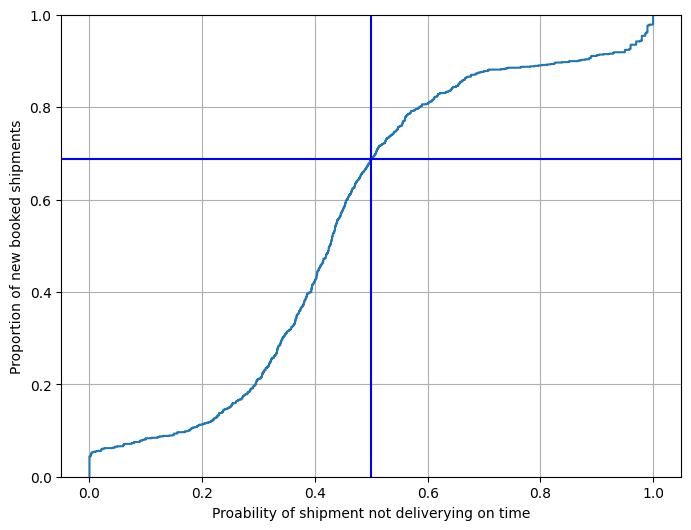

In [109]:
### Plot probability of shipment not deliverying on time!

fig = plt.pyplot.figure(figsize=(8, 6))
sns.ecdfplot(data=df_nb, x='prob_1')
plt.pyplot.axvline(x=0.5 , color='b')
plt.pyplot.axhline(y=(1-0.3127), color='b')

plt.pyplot.xlabel('Proability of shipment not deliverying on time')
plt.pyplot.ylabel('Proportion of new booked shipments')

plt.pyplot.grid('show')
plt.pyplot.show()
fig.savefig('plot_2.png', dpi=500)

In [110]:
df_nb.groupby('CARRIER_SIZE').agg({'prob_1': 'mean'})

prob_1
CARRIER_SIZE          
BIG           0.107682
MEDIUM        0.375060
SMALL         0.431723
VERY SMALL    0.629463

In [111]:
df_nb.groupby('CARRIER_EFFICIENCY').agg({'prob_1': 'mean'})

prob_1
CARRIER_EFFICIENCY          
BAD                 0.554565
GOOD                0.203838
OKAY                0.411607
VERY BAD            0.970686

In [112]:
df_nb.groupby('delivery_period').agg({'prob_1': 'mean'})

prob_1
delivery_period          
Early Morning    0.412106
Evening          0.467949
Late Night       0.445919
Morning          0.480375
Night            0.416721
Noon             0.439403

In [113]:
df_nb.groupby('delivery_dow').agg({'prob_1': 'mean'})

prob_1
delivery_dow          
0             0.464950
1             0.463640
2             0.453021
3             0.428988
4             0.453021
5             0.445224
6             0.424347

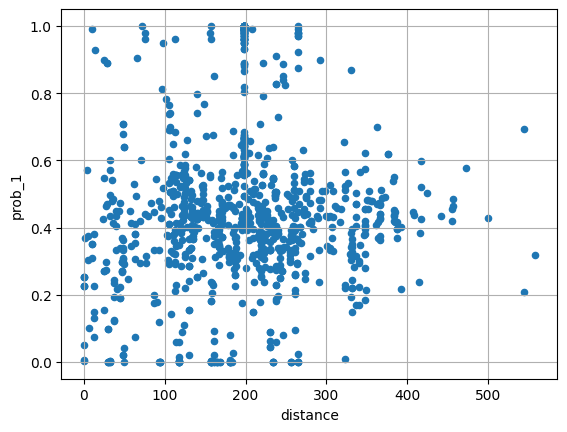

In [114]:
df_nb.plot(x='distance', y='prob_1', kind='scatter')
plt.pyplot.grid('show')
plt.pyplot.show()

# Scratch PAD
## Random bits of queries and exploration which shaped the work above!

In [24]:
### Let's join shipment booking and gps data together according to "arriving no later than 30 minutes past the scheduled delivery window"

#df_sb['LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30'] = pd.to_datetime(df_sb['LAST_DELIVERY_SCHEDULE_LATEST_lcl']) + pd.to_timedelta(30, unit='minute')

query_14 = """select sb.*, MAX(gps.RECORD_TIMESTAMP_lcl) as latest_GPS_RECORD_TIMESTAMP     
            from df_sb AS sb
            left join df_GPS AS gps
            on sb.SHIPMENT_NUMBER = gps.SHIPMENT_NUMBER 
            AND gps.RECORD_TIMESTAMP_lcl <= LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30
            AND DATE(LAST_DELIVERY_SCHEDULE_LATEST_lcl) BETWEEN '2023-10-01' AND '2023-12-31'
            group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19"""
 
output_14 = sqldf.run(query_14).drop(columns=['index'])

print(output_14.shape)

output_14.head()

(3245, 21)


PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   
2  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231210-272018   
3  40415fe3-e446-4d1e-b141-3698b0dc47f3  SEZHUK-231211-272127   
4  39a4e234-5d35-4d94-8e8a-b8bf6fe13953  SEZHUK-231025-256168   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000660  Tractor Unit                    Box 44ft   
2         CAUK000435  Tractor Unit                    Box 44ft   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000155  Tractor Unit                Curtain Side   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                    BD5 8LZ                RG19 4BQ   
2                    BD5 8LZ                 EN3 7QP   
3                   HP22 5BL                NG31 7UH   
4                   CV23 8BQ                 G75 0ZZ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  53.764125                   -1.740145   
2                  53.767302                   -1.746560   
3                  51.779657                   -0.772897   
4                  52.334853                   -1.180450   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               51.398851                -1.231993   
2               51.660700                -0.022247   
3               52.888113                -0.634948   
4               55.735089                -4.168719   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   
2           2023-12-14T01:20:00.000Z         2023-12-14T03:00:00.000Z   
3           2023-12-13T09:00:00.000Z         2023-12-13T09:30:00.000Z   
4           2023-11-07T14:00:00.000Z         2023-11-07T15:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  \
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
1        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z   
2        2023-12-14T07:03:00.000Z      2023-12-14T10:43:00.000Z   
3        2023-12-13T15:30:00.000Z      2023-12-13T16:00:00.000Z   
4        2023-11-07T23:00:00.000Z      2023-11-07T23:59:00.000Z   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
1              2023-12-19 14:20:00+00:00            2023-12-19 16:00:00+00:00   
2              2023-12-14 01:20:00+00:00            2023-12-14 03:00:00+00:00   
3              2023-12-13 09:00:00+00:00            2023-12-13 09:30:00+00:00   
4              2023-11-07 14:00:00+00:00            2023-11-07 15:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
1           2023-12-20 06:00:00+00:00         2023-12-20 08:56:00+00:00   
2           2023-12-14 07:03:00+00:00         2023-12-14 10:43:00+00:00   
3           2023-12-13 15:30:00+00:00         2023-12-13 16:00:00+00:00   
4           2023-11-07 23:00:00+00:00         2023-11-07 23:59:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30 latest_GPS_RECORD_TIMESTAMP  
0                2023-10-09 10:55:00+00:00   2023-10-06 09:24:00+00:00  
1                2023-12-20 09:26:00+00:00   2023-12-20 04:08:00+00:00  
2                2023-12-14 11:13:00+00:00   2023-12-14 10:18:00+00:00  
3                2023-12-13 16:30:00+00:00   2023-12-13 16:23:00+00:00  
4                2023-11-08 00:29:00+00:00   2023-11-08 00:29:00+00:00

In [25]:
len(output_14[output_14['latest_GPS_RECORD_TIMESTAMP'].isna()])

371

In [28]:
query_15 = """select o14.*, gps.LAT, gps.LON     
            from output_14 AS o14
            join df_GPS AS gps
            on o14.SHIPMENT_NUMBER = gps.SHIPMENT_NUMBER 
            AND gps.RECORD_TIMESTAMP_lcl = o14.latest_GPS_RECORD_TIMESTAMP
            AND o14.LAST_DELIVERY_POST_CODE is NOT NULL
            """
 
output_15 = sqldf.run(query_15).drop(columns=['index'])

print(output_15.shape)

output_15.head()

(2870, 23)


PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   
2  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231210-272018   
3  40415fe3-e446-4d1e-b141-3698b0dc47f3  SEZHUK-231211-272127   
4  39a4e234-5d35-4d94-8e8a-b8bf6fe13953  SEZHUK-231025-256168   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000660  Tractor Unit                    Box 44ft   
2         CAUK000435  Tractor Unit                    Box 44ft   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000155  Tractor Unit                Curtain Side   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                    BD5 8LZ                RG19 4BQ   
2                    BD5 8LZ                 EN3 7QP   
3                   HP22 5BL                NG31 7UH   
4                   CV23 8BQ                 G75 0ZZ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  53.764125                   -1.740145   
2                  53.767302                   -1.746560   
3                  51.779657                   -0.772897   
4                  52.334853                   -1.180450   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               51.398851                -1.231993   
2               51.660700                -0.022247   
3               52.888113                -0.634948   
4               55.735089                -4.168719   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   
2           2023-12-14T01:20:00.000Z         2023-12-14T03:00:00.000Z   
3           2023-12-13T09:00:00.000Z         2023-12-13T09:30:00.000Z   
4           2023-11-07T14:00:00.000Z         2023-11-07T15:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  \
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
1        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z   
2        2023-12-14T07:03:00.000Z      2023-12-14T10:43:00.000Z   
3        2023-12-13T15:30:00.000Z      2023-12-13T16:00:00.000Z   
4        2023-11-07T23:00:00.000Z      2023-11-07T23:59:00.000Z   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
1              2023-12-19 14:20:00+00:00            2023-12-19 16:00:00+00:00   
2              2023-12-14 01:20:00+00:00            2023-12-14 03:00:00+00:00   
3              2023-12-13 09:00:00+00:00            2023-12-13 09:30:00+00:00   
4              2023-11-07 14:00:00+00:00            2023-11-07 15:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
1           2023-12-20 06:00:00+00:00         2023-12-20 08:56:00+00:00   
2           2023-12-14 07:03:00+00:00         2023-12-14 10:43:00+00:00   
3           2023-12-13 15:30:00+00:00         2023-12-13 16:00:00+00:00   
4           2023-11-07 23:00:00+00:00         2023-11-07 23:59:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30 latest_GPS_RECORD_TIMESTAMP  \
0                2023-10-09 10:55:00+00:00   2023-10-06 09:24:00+00:00   
1                2023-12-20 09:26:00+00:00   2023-12-20 04:08:00+00:00   
2                2023-12-14 11:13:00+00:00   2023-12-14 10:18:00+00:00   
3                2023-12-13 16:30:00+00:00   2023-12-13 16:23:00+00:00   
4                2023-11-08 00:29:00+00:00   2023-11-08 00:29:00+00:

In [29]:
output_15['is_delivered'] = 0
is_delivered = []

for (i, j, k) in output_15[['LAT', 'LON', 'LAST_DELIVERY_POST_CODE']].values:
    #print(j, i, k[0:3])
    df_1 = get_data_from_lon_lat(j, i)
    df_2 = get_data_from_post_codes(k)
    if df_1 is not None and df_2 is not None:
        #print(df_2.outcode.values[0], df_1.outcode.values)
        if df_2.outcode.values[0] in df_1.outcode.values:
            is_delivered.append(1)
        else:
            is_delivered.append(0)
    else:
        is_delivered.append(0)

    if (len(is_delivered)%100)==0:
        print(len(is_delivered), ' out of ', output_15.shape[0], ' rows completed.')
    if (len(is_delivered) == output_15.shape[0]):
        print('Calculations completed.')

100  out of  2870  rows completed.
200  out of  2870  rows completed.
300  out of  2870  rows completed.
400  out of  2870  rows completed.
500  out of  2870  rows completed.
600  out of  2870  rows completed.
700  out of  2870  rows completed.
800  out of  2870  rows completed.
900  out of  2870  rows completed.
1000  out of  2870  rows completed.
1100  out of  2870  rows completed.
1200  out of  2870  rows completed.
1300  out of  2870  rows completed.
1400  out of  2870  rows completed.
1500  out of  2870  rows completed.
1600  out of  2870  rows completed.
1700  out of  2870  rows completed.
1800  out of  2870  rows completed.
1900  out of  2870  rows completed.
2000  out of  2870  rows completed.
2100  out of  2870  rows completed.
2200  out of  2870  rows completed.
2300  out of  2870  rows completed.
2400  out of  2870  rows completed.
2500  out of  2870  rows completed.
2600  out of  2870  rows completed.
2700  out of  2870  rows completed.
2800  out of  2870  rows completed.
C

[0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,


In [30]:
len(is_delivered)

2870

In [32]:
sum(is_delivered)/len(is_delivered)

0.5181184668989547

In [33]:
### Let get the distance (in km) between last delivery location (lat/lon) and gps location (lat/lon)

output_15 = get_distance(output_15)

output_15.head()

PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   
2  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231210-272018   
3  40415fe3-e446-4d1e-b141-3698b0dc47f3  SEZHUK-231211-272127   
4  39a4e234-5d35-4d94-8e8a-b8bf6fe13953  SEZHUK-231025-256168   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000660  Tractor Unit                    Box 44ft   
2         CAUK000435  Tractor Unit                    Box 44ft   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000155  Tractor Unit                Curtain Side   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                    BD5 8LZ                RG19 4BQ   
2                    BD5 8LZ                 EN3 7QP   
3                   HP22 5BL                NG31 7UH   
4                   CV23 8BQ                 G75 0ZZ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  53.764125                   -1.740145   
2                  53.767302                   -1.746560   
3                  51.779657                   -0.772897   
4                  52.334853                   -1.180450   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               51.398851                -1.231993   
2               51.660700                -0.022247   
3               52.888113                -0.634948   
4               55.735089                -4.168719   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   
2           2023-12-14T01:20:00.000Z         2023-12-14T03:00:00.000Z   
3           2023-12-13T09:00:00.000Z         2023-12-13T09:30:00.000Z   
4           2023-11-07T14:00:00.000Z         2023-11-07T15:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  \
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
1        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z   
2        2023-12-14T07:03:00.000Z      2023-12-14T10:43:00.000Z   
3        2023-12-13T15:30:00.000Z      2023-12-13T16:00:00.000Z   
4        2023-11-07T23:00:00.000Z      2023-11-07T23:59:00.000Z   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
1              2023-12-19 14:20:00+00:00            2023-12-19 16:00:00+00:00   
2              2023-12-14 01:20:00+00:00            2023-12-14 03:00:00+00:00   
3              2023-12-13 09:00:00+00:00            2023-12-13 09:30:00+00:00   
4              2023-11-07 14:00:00+00:00            2023-11-07 15:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
1           2023-12-20 06:00:00+00:00         2023-12-20 08:56:00+00:00   
2           2023-12-14 07:03:00+00:00         2023-12-14 10:43:00+00:00   
3           2023-12-13 15:30:00+00:00         2023-12-13 16:00:00+00:00   
4           2023-11-07 23:00:00+00:00         2023-11-07 23:59:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30 latest_GPS_RECORD_TIMESTAMP  \
0                2023-10-09 10:55:00+00:00   2023-10-06 09:24:00+00:00   
1                2023-12-20 09:26:00+00:00   2023-12-20 04:08:00+00:00   
2                2023-12-14 11:13:00+00:00   2023-12-14 10:18:00+00:00   
3                2023-12-13 16:30:00+00:00   2023-12-13 16:23:00+00:00   
4                2023-11-08 00:29:00+00:00   2023-11-08 00:29:00+00:

In [37]:
output_15['is_delivered'] = is_delivered

output_15.to_csv('output_15.csv')

In [2]:
output_15 = pd.read_csv('output_15.csv', index_col=0)

output_15.head()

PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   
2  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231210-272018   
3  40415fe3-e446-4d1e-b141-3698b0dc47f3  SEZHUK-231211-272127   
4  39a4e234-5d35-4d94-8e8a-b8bf6fe13953  SEZHUK-231025-256168   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000660  Tractor Unit                    Box 44ft   
2         CAUK000435  Tractor Unit                    Box 44ft   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000155  Tractor Unit                Curtain Side   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                    BD5 8LZ                RG19 4BQ   
2                    BD5 8LZ                 EN3 7QP   
3                   HP22 5BL                NG31 7UH   
4                   CV23 8BQ                 G75 0ZZ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  53.764125                   -1.740145   
2                  53.767302                   -1.746560   
3                  51.779657                   -0.772897   
4                  52.334853                   -1.180450   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               51.398851                -1.231993   
2               51.660700                -0.022247   
3               52.888113                -0.634948   
4               55.735089                -4.168719   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   
2           2023-12-14T01:20:00.000Z         2023-12-14T03:00:00.000Z   
3           2023-12-13T09:00:00.000Z         2023-12-13T09:30:00.000Z   
4           2023-11-07T14:00:00.000Z         2023-11-07T15:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  \
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
1        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z   
2        2023-12-14T07:03:00.000Z      2023-12-14T10:43:00.000Z   
3        2023-12-13T15:30:00.000Z      2023-12-13T16:00:00.000Z   
4        2023-11-07T23:00:00.000Z      2023-11-07T23:59:00.000Z   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
1              2023-12-19 14:20:00+00:00            2023-12-19 16:00:00+00:00   
2              2023-12-14 01:20:00+00:00            2023-12-14 03:00:00+00:00   
3              2023-12-13 09:00:00+00:00            2023-12-13 09:30:00+00:00   
4              2023-11-07 14:00:00+00:00            2023-11-07 15:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
1           2023-12-20 06:00:00+00:00         2023-12-20 08:56:00+00:00   
2           2023-12-14 07:03:00+00:00         2023-12-14 10:43:00+00:00   
3           2023-12-13 15:30:00+00:00         2023-12-13 16:00:00+00:00   
4           2023-11-07 23:00:00+00:00         2023-11-07 23:59:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30 latest_GPS_RECORD_TIMESTAMP  \
0                2023-10-09 10:55:00+00:00   2023-10-06 09:24:00+00:00   
1                2023-12-20 09:26:00+00:00   2023-12-20 04:08:00+00:00   
2                2023-12-14 11:13:00+00:00   2023-12-14 10:18:00+00:00   
3                2023-12-13 16:30:00+00:00   2023-12-13 16:23:00+00:00   
4                2023-11-08 00:29:00+00:00   2023-11-08 00:29:00+00:

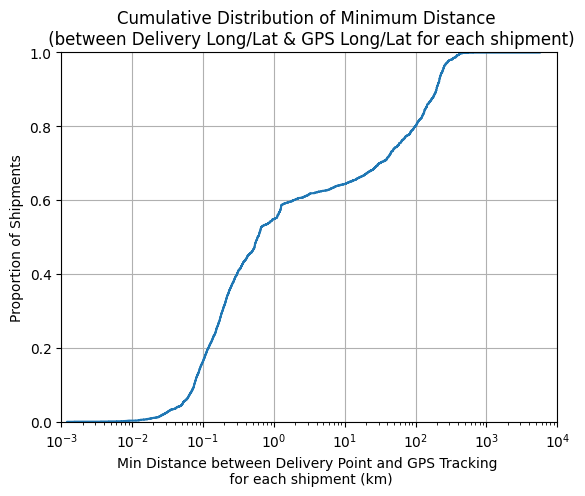

In [3]:
### plot a cumulative histogram of the above minimum distance

get_cumulative_histogram(output_15[output_15.distance.isna() == False], X='distance')

In [4]:
output_15['is_delivered_2'] = 0
is_delivered_2 = []

for (i, j, k, l) in output_15[['LAT', 'LON', 'LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE']].values:
    #print(j, i, k, l)
    df_1 = get_data_from_lon_lat(j, i)
    df_2 = get_data_from_lon_lat(l, k)
    if df_1 is not None and df_2 is not None:
        #print(df_2.outcode.values, df_1.outcode.values)
        if df_2.outcode.values[0] == df_1.outcode.values[0]:
            is_delivered_2.append(1)
        else:
            is_delivered_2.append(0)
    else:
        is_delivered_2.append(0)

    if (len(is_delivered_2)%100)==0:
        print(len(is_delivered_2), ' out of ', output_15.shape[0], ' rows completed.')
    if (len(is_delivered_2) == output_15.shape[0]):
        print('Calculations completed.')

output_15['is_delivered_2'] = is_delivered_2

100  out of  2870  rows completed.
200  out of  2870  rows completed.
300  out of  2870  rows completed.
400  out of  2870  rows completed.
500  out of  2870  rows completed.
600  out of  2870  rows completed.
700  out of  2870  rows completed.
800  out of  2870  rows completed.
900  out of  2870  rows completed.
1000  out of  2870  rows completed.
1100  out of  2870  rows completed.
1200  out of  2870  rows completed.
1300  out of  2870  rows completed.
1400  out of  2870  rows completed.
1500  out of  2870  rows completed.
1600  out of  2870  rows completed.
1700  out of  2870  rows completed.
1800  out of  2870  rows completed.
1900  out of  2870  rows completed.
2000  out of  2870  rows completed.
2100  out of  2870  rows completed.
2200  out of  2870  rows completed.
2300  out of  2870  rows completed.
2400  out of  2870  rows completed.
2500  out of  2870  rows completed.
2600  out of  2870  rows completed.
2700  out of  2870  rows completed.
2800  out of  2870  rows completed.
C

In [11]:
sum(output_15.is_delivered)

1487

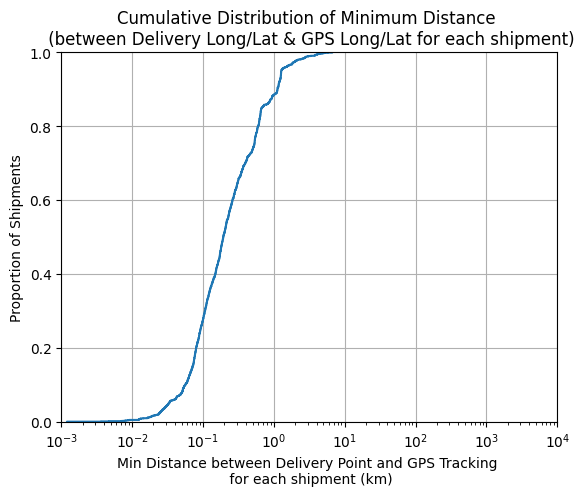

In [9]:
### plot a cumulative histogram of the above minimum distance

get_cumulative_histogram(output_15[output_15.is_delivered == 1], X='distance')

In [22]:




output_14 = get_distance(output_14)

query_16 = """select SHIPMENT_NUMBER, MIN(distance) AS min_distance 
            from output_14
            group by SHIPMENT_NUMBER"""
 
output_16 = sqldf.run(query_16)

print(output_16.shape)

output_16.head()

(3245, 2)


SHIPMENT_NUMBER  min_distance
0  SEZHUK-230918-245388    375.692475
1  SEZHUK-230919-245487      0.025140
2  SEZHUK-230919-245488      0.147250
3  SEZHUK-230919-245489      0.052472
4  SEZHUK-230919-245490      0.286499

In [23]:
output_16[output_16.min_distance.isna()].shape

(364, 2)

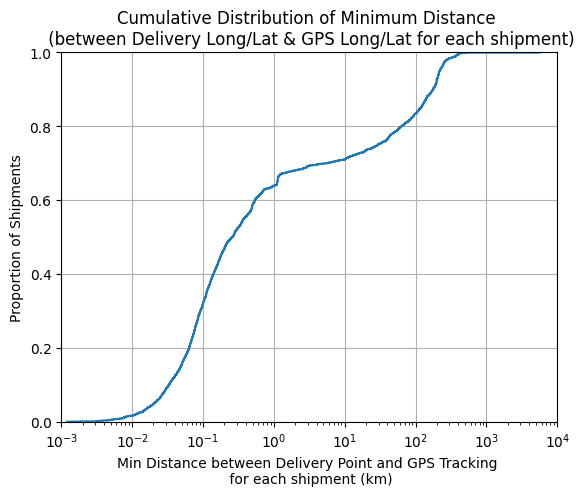

In [24]:
### plot a cumulative histogram of the above minimum distance

get_cumulative_histogram(output_16[output_16.min_distance.isna() == False])

In [25]:
###


query_17 = """select o14.*
            from output_14 AS o14
            join output_16 AS o16
            on o14.SHIPMENT_NUMBER = o16.SHIPMENT_NUMBER AND o14.distance = o16.min_distance
            """
 
output_17 = sqldf.run(query_17)

print(output_17.shape)

output_17.head()

(3091, 26)


index  level_0                            PROJECT_ID       SHIPMENT_NUMBER  \
0      0        1  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1      1        4  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   
2      2      135  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231210-272018   
3      3      791  40415fe3-e446-4d1e-b141-3698b0dc47f3  SEZHUK-231211-272127   
4      4     1178  39a4e234-5d35-4d94-8e8a-b8bf6fe13953  SEZHUK-231025-256168   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000660  Tractor Unit                    Box 44ft   
2         CAUK000435  Tractor Unit                    Box 44ft   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000155  Tractor Unit                Curtain Side   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                    BD5 8LZ                RG19 4BQ   
2                    BD5 8LZ                 EN3 7QP   
3                   HP22 5BL                NG31 7UH   
4                   CV23 8BQ                 G75 0ZZ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  53.764125                   -1.740145   
2                  53.767302                   -1.746560   
3                  51.779657                   -0.772897   
4                  52.334853                   -1.180450   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               51.398851                -1.231993   
2               51.660700                -0.022247   
3               52.888113                -0.634948   
4               55.735089                -4.168719   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   
2           2023-12-14T01:20:00.000Z         2023-12-14T03:00:00.000Z   
3           2023-12-13T09:00:00.000Z         2023-12-13T09:30:00.000Z   
4           2023-11-07T14:00:00.000Z         2023-11-07T15:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  \
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
1        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z   
2        2023-12-14T07:03:00.000Z      2023-12-14T10:43:00.000Z   
3        2023-12-13T15:30:00.000Z      2023-12-13T16:00:00.000Z   
4        2023-11-07T23:00:00.000Z      2023-11-07T23:59:00.000Z   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
1              2023-12-19 14:20:00+00:00            2023-12-19 16:00:00+00:00   
2              2023-12-14 01:20:00+00:00            2023-12-14 03:00:00+00:00   
3              2023-12-13 09:00:00+00:00            2023-12-13 09:30:00+00:00   
4              2023-11-07 14:00:00+00:00            2023-11-07 15:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
1           2023-12-20 06:00:00+00:00         2023-12-20 08:56:00+00:00   
2           2023-12-14 07:03:00+00:00         2023-12-14 10:43:00+00:00   
3           2023-12-13 15:30:00+00:00         2023-12-13 16:00:00+00:00   
4           2023-11-07 23:00:00+00:00         2023-11-07 23:59:00+00:00   

  LAST_DELIVERY_SCHEDULE_LATEST_lcl_plus30        LAT       LON  \
0                2023-10-09 10:55:00+00:00  52.316440 -0.157995   
1                2023-12-20 09:26:00+00:00  53.408830 -1.365270   
2                2023-12-14 11:13:00+00:00  51.660383 -0.022310   
3                2023-12-13 16:30:00+00:00  52.8

### Exploratory Data Analysis

#### As given data is unlabelled (shipment_delayed = True/False), EDA to get the best data labelling stratgey.

In [11]:
### number of shipments in shipment booking data

query_1 = """select count(distinct PROJECT_ID) as project_count
                  ,count(distinct SHIPMENT_NUMBER) as shipment_count      
            from df_sb"""
 
output_1 = sqldf.run(query_1)

output_1

project_count  shipment_count
0             49            3245

In [12]:
### number of shipments in gps data which are also present in shipment booking data

query_2 = """SELECT COUNT(DISTINCT gps.SHIPMENT_NUMBER) FROM df_GPS AS gps
             inner join df_sb AS sb 
             on gps.SHIPMENT_NUMBER = sb.SHIPMENT_NUMBER"""
 
output_2 = sqldf.run(query_2)

output_2

COUNT(DISTINCT gps.SHIPMENT_NUMBER)
0                                 3245

In [13]:
### Assuming a shipment is considered delivered if there is a GPS location (lon/lat)... 
### matches upto 2 decimal points with last delivery location (lon/lat)

query_3 = """select sb.*, gps.LAT, gps.LON, gps.RECORD_TIMESTAMP     
            from df_sb AS sb
            left join df_GPS AS gps
            on sb.SHIPMENT_NUMBER = gps.SHIPMENT_NUMBER AND round(sb.LAST_DELIVERY_LATITUDE,2) = round(gps.LAT,2) \
            AND round(sb.LAST_DELIVERY_LONGITUDE,2) = round(gps.LON,2)"""
 
output_3 = sqldf.run(query_3)

query_4 = """select count(distinct SHIPMENT_NUMBER) from output_3 where LAT is NOT NULL AND LON IS NOT NULL"""

output_4 = sqldf.run(query_4)

output_4   

count(distinct SHIPMENT_NUMBER)
0                             1876

In [14]:
### Assuming a shipment is considered delivered if there is a GPS location (lon/lat)... 
### matches upto 1 decimal points with last delivery location (lon/lat)

query_5 = """select sb.*, gps.LAT, gps.LON, gps.RECORD_TIMESTAMP     
            from df_sb AS sb
            left join df_GPS AS gps
            on sb.SHIPMENT_NUMBER = gps.SHIPMENT_NUMBER AND round(sb.LAST_DELIVERY_LATITUDE,1) = round(gps.LAT,1) \
            AND round(sb.LAST_DELIVERY_LONGITUDE,1) = round(gps.LON,1)"""
 
output_5 = sqldf.run(query_5)

query_6 = """select count(distinct SHIPMENT_NUMBER) from output_5 where LAT is NOT NULL OR LON IS NOT NULL"""

output_6 = sqldf.run(query_6)

output_6   

count(distinct SHIPMENT_NUMBER)
0                             2428

In [15]:
### Let's join shipment booking and gps data together for further exploration!

query_7 = """select sb.*, gps.LAT, gps.LON, gps.RECORD_TIMESTAMP     
            from df_sb AS sb
            left join df_GPS AS gps
            on sb.SHIPMENT_NUMBER = gps.SHIPMENT_NUMBER"""
 
output_7 = sqldf.run(query_7)

print(output_7.shape)

output_7.head()

(641662, 23)


index                            PROJECT_ID       SHIPMENT_NUMBER  \
0      0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1      0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
2      0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
3      0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
4      1  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
2         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000660  Tractor Unit                    Box 44ft   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                   PE29 2XR                EH48 2FB   
2                   PE29 2XR                EH48 2FB   
3                   PE29 2XR                EH48 2FB   
4                    BD5 8LZ                RG19 4BQ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  52.315672                   -0.157664   
2                  52.315672                   -0.157664   
3                  52.315672                   -0.157664   
4                  53.764125                   -1.740145   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               55.877803                -3.648558   
2               55.877803                -3.648558   
3               55.877803                -3.648558   
4               51.398851                -1.231993   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
2           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
3           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
4           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  \
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
1        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
2        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
3        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
4        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
1              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
2              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
3              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
4              2023-12-19 14:20:00+00:00            2023-12-19 16:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
1           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
2           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
3           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
4           2023-12-20 06:00:00+00:00         2023-12-20 08:56:00+00:00   

         LAT       LON              RECORD_TIMESTAMP  
0  52.316349 -0.156690  2023-10-06T09:58:00.000+0100  
1  52.316440 -0.157995  2023-10-06T10:05:00.000+0100  
2  52.316544 -0.157263  2023-10-06T10:24:00.000+0100  
3  52.316602 -0.157301  2023-10-06T10:03:00.000+0100  
4  53.408830 -1.365270      2023-12-20T03:51:00.000Z

In [16]:
### Let get the distance (in km) between last delivery location (lat/lon) and gps location (lat/lon)

output_7 = get_distance(output_7)

output_7.head()

PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
2  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
3  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
4  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
2         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000660  Tractor Unit                    Box 44ft   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                   PE29 2XR                EH48 2FB   
2                   PE29 2XR                EH48 2FB   
3                   PE29 2XR                EH48 2FB   
4                    BD5 8LZ                RG19 4BQ   

   FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
0                  52.315672                   -0.157664   
1                  52.315672                   -0.157664   
2                  52.315672                   -0.157664   
3                  52.315672                   -0.157664   
4                  53.764125                   -1.740145   

   LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  \
0               55.877803                -3.648558   
1               55.877803                -3.648558   
2               55.877803                -3.648558   
3               55.877803                -3.648558   
4               51.398851                -1.231993   

  FIRST_COLLECTION_SCHEDULE_EARLIEST FIRST_COLLECTION_SCHEDULE_LATEST  \
0           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
1           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
2           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
3           2023-10-06T09:45:00.000Z         2023-10-06T10:00:00.000Z   
4           2023-12-19T14:20:00.000Z         2023-12-19T16:00:00.000Z   

  LAST_DELIVERY_SCHEDULE_EARLIEST LAST_DELIVERY_SCHEDULE_LATEST  \
0        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
1        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
2        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
3        2023-10-09T09:55:00.000Z      2023-10-09T10:25:00.000Z   
4        2023-12-20T06:00:00.000Z      2023-12-20T08:56:00.000Z   

  FIRST_COLLECTION_SCHEDULE_EARLIEST_lcl FIRST_COLLECTION_SCHEDULE_LATEST_lcl  \
0              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
1              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
2              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
3              2023-10-06 09:45:00+00:00            2023-10-06 10:00:00+00:00   
4              2023-12-19 14:20:00+00:00            2023-12-19 16:00:00+00:00   

  LAST_DELIVERY_SCHEDULE_EARLIEST_lcl LAST_DELIVERY_SCHEDULE_LATEST_lcl  \
0           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
1           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
2           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
3           2023-10-09 09:55:00+00:00         2023-10-09 10:25:00+00:00   
4           2023-12-20 06:00:00+00:00         2023-12-20 08:56:00+00:00   

         LAT       LON              RECORD_TIMESTAMP    distance  
0  52.316349 -0.156690  2023-10-06T09:58:00.000+0100  456.815026  
1  52.316440 -0.157995  2023-10-06T10:05:00.000+0100  456.763771  
2  52.316544 -0.157263  2023-10-06T10:24:00.000+0100  456.777358  
3  52.316602 -0.157301  2023-10-06T10:03:00.000+0100  456.770483  
4  53.408830 -1.365270      2023-12-20T03:51:00.000Z  223.752409

In [17]:
### Let's get minimum distance for each shipment

query_8 = """select SHIPMENT_NUMBER, MIN(distance) AS min_distance 
            from output_7
            group by 1
            """
 
output_8 = sqldf.run(query_8)

print(output_8.shape)

output_8.head()

(3245, 2)


SHIPMENT_NUMBER  min_distance
0  SEZHUK-230918-245388      1.233151
1  SEZHUK-230919-245487      0.025140
2  SEZHUK-230919-245488      0.147250
3  SEZHUK-230919-245489      0.052472
4  SEZHUK-230919-245490      0.286499

In [18]:
### distribution summary of minimum distance (between delivery location and closest gps location)

output_8[['min_distance']].describe([.01,.1,.2,.3,.4,.5,.6,.7,0.71,0.72,0.73,0.74,0.75,.8,.9,.99])

min_distance
count   3245.000000
mean      35.950678
std      159.874886
min        0.001202
1%         0.007190
10%        0.030458
20%        0.057397
30%        0.079459
40%        0.111011
50%        0.165654
60%        0.339452
70%        0.946534
71%        1.115841
72%        1.137735
73%        1.220329
74%        1.843256
75%        2.893591
80%       33.743520
90%      140.862094
99%      336.940195
max     5729.231215

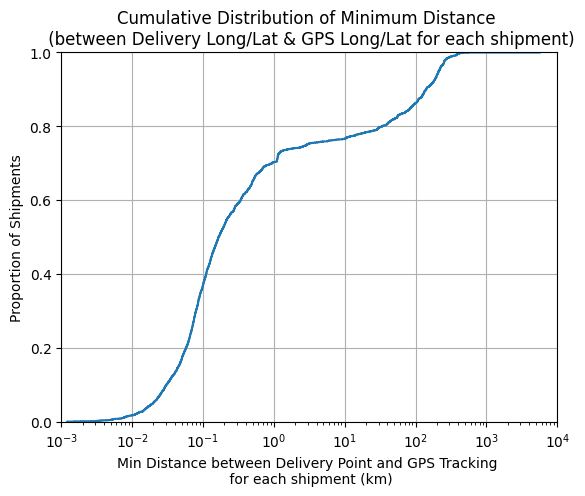

In [19]:
### plot a cumulative histogram of the above minimum distance

get_cumulative_histogram(output_8)

In [20]:
### Let's get the minimum distance for shipments where a GPS location (lon/lat)... 
### matches upto 2 decimal points with last delivery location (lon/lat)

query_9 = """select sb.*, gps.LAT, gps.LON, gps.RECORD_TIMESTAMP     
            from df_sb AS sb
            left join df_GPS AS gps
            on sb.SHIPMENT_NUMBER = gps.SHIPMENT_NUMBER AND round(sb.LAST_DELIVERY_LATITUDE,2) = round(gps.LAT,2) \
            AND round(sb.LAST_DELIVERY_LONGITUDE,2) = round(gps.LON,2)"""
 
output_9 = sqldf.run(query_9)

output_9 = get_distance(output_9)

query_10 = """select SHIPMENT_NUMBER, MIN(distance) AS min_distance 
            from output_9
            where distance is not null
            group by 1
            """
 
output_10 = sqldf.run(query_10)

print(output_10.shape)

output_10.head()

(1876, 2)


SHIPMENT_NUMBER  min_distance
0  SEZHUK-230919-245487      0.025140
1  SEZHUK-230919-245488      0.147250
2  SEZHUK-230919-245489      0.052472
3  SEZHUK-230919-245490      0.286499
4  SEZHUK-230919-245491      0.285145

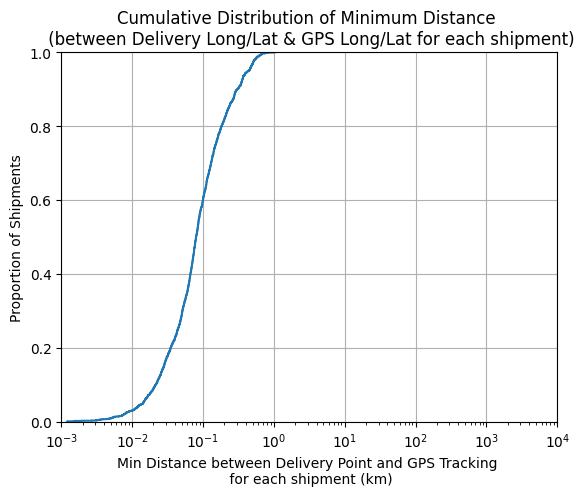

In [21]:
### plot a cumulative histogram of the above minimum distance (from above)

get_cumulative_histogram(output_10)

In [22]:
### distribution summary of minimum distance (from above)

output_10.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

min_distance
count   1876.000000
mean       0.126243
std        0.132008
min        0.001202
1%         0.005128
10%        0.021540
20%        0.035010
30%        0.051293
40%        0.066379
50%        0.079798
60%        0.099709
70%        0.129807
80%        0.183022
90%        0.304571
99%        0.619239
max        1.028942

In [23]:
### shipment with min_distance greater than 1 kilometer ( out of shipment where a GPS location (lon/lat)... 
### matches upto 2 decimal points with last delivery location (lon/lat) )

output_10[output_10.min_distance > 1].shape

(1, 2)

In [24]:
### Let's repeat the similar analysis for last recorded GPS timestamp and location (lat/lon)
### Getting the last recorded location of each shipment using max(Record_Timestamp)

query_11a = """select SHIPMENT_NUMBER, max(RECORD_TIMESTAMP) as RECORD_TIMESTAMP
              from df_GPS
              group by 1"""

output_11a = sqldf.run(query_11a)

query_11b = """select gps_a.*
              from df_GPS AS gps_a
              join output_11a AS gps_b
              on gps_a.SHIPMENT_NUMBER = gps_b.SHIPMENT_NUMBER AND gps_a.RECORD_TIMESTAMP = gps_b.RECORD_TIMESTAMP"""

output_11b = sqldf.run(query_11b)

print(output_11b.shape)

output_11b.head()

(3245, 6)


index       SHIPMENT_NUMBER        LAT       LON  \
0     13  SEZHUK-230918-245388  52.277015 -8.276215   
1    118  SEZHUK-230919-245487  53.260643 -1.318575   
2    185  SEZHUK-230919-245488  53.259834 -1.319917   
3    251  SEZHUK-230919-245489  52.907932 -1.462328   
4    308  SEZHUK-230919-245490  53.260650 -1.318117   

               RECORD_TIMESTAMP       RECORD_TIMESTAMP_lcl  
0  2023-10-11T11:50:00.000+0100  2023-10-11 10:50:00+00:00  
1      2023-11-30T15:59:00.000Z  2023-11-30 15:59:00+00:00  
2  2023-10-12T13:08:00.000+0100  2023-10-12 12:08:00+00:00  
3      2023-11-09T17:51:00.000Z  2023-11-09 17:51:00+00:00  
4      2023-11-02T16:29:00.000Z  2023-11-02 16:29:00+00:00

In [25]:
### Let's get the distance between last recorded gps location and delivery location of each shipment

query_12 = """select sb.*, gps.LAT, gps.LON, gps.RECORD_TIMESTAMP     
            from df_sb AS sb
            left join output_11b AS gps
            on sb.SHIPMENT_NUMBER = gps.SHIPMENT_NUMBER"""
 
output_12 = sqldf.run(query_12)

output_12 = get_distance(output_12)

query_13 = """select SHIPMENT_NUMBER, MIN(distance) AS min_distance 
            from output_12
            where distance is not null
            group by 1
            """
 
output_13 = sqldf.run(query_13)

print(output_13.shape)

output_13.head()

(3245, 2)


SHIPMENT_NUMBER  min_distance
0  SEZHUK-230918-245388      1.233151
1  SEZHUK-230919-245487      0.268415
2  SEZHUK-230919-245488      0.147250
3  SEZHUK-230919-245489     40.135800
4  SEZHUK-230919-245490      0.286499

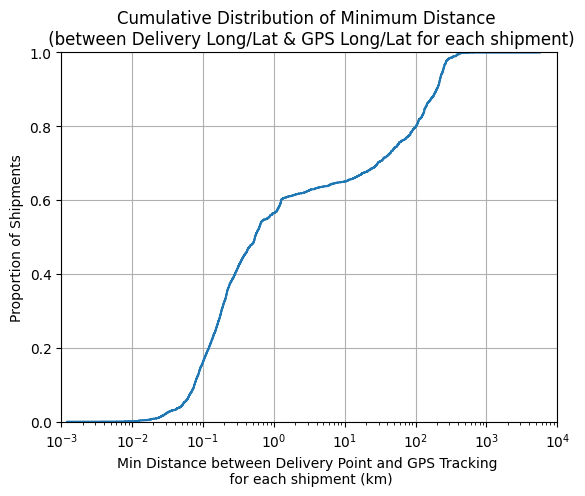

In [26]:
get_cumulative_histogram(output_13)

In [27]:
### distribution summary of minimum distance (from above)

output_13.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

min_distance
count   3245.000000
mean      51.169494
std      165.301147
min        0.001202
1%         0.022204
10%        0.075663
20%        0.120973
30%        0.181636
40%        0.281801
50%        0.541342
60%        1.271094
70%       29.224173
80%      100.857057
90%      198.212959
99%      372.281797
max     5729.231215